In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline


In [6]:
lineage_order = ["driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::before_predict",
                     "container::after_predict",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv",
                     "clipper::task_executor_recv_end",
                     "clipper::task_executor_msg_callback_found",
                     "clipper::zmq_frontend_response_callback", 
                     "clipper::frontend_rpc_response_send", 
                     "driver::recv"]

points_to_include = [
#     "driver::send",                  
    "clipper::frontend_rpc_recv", 
    "clipper::task_enqueued",
    "clipper::task_dequeued",
    "clipper::sent_rpc",
    "container::recv",
    "container::before_predict",
    "container::after_predict",
    "container::send",
    "clipper::rpc_recv",
    "clipper::task_executor_recv",
    "clipper::task_executor_msg_callback_found",
    "clipper::task_executor_recv_end",
    "clipper::zmq_frontend_response_callback",
    "clipper::frontend_rpc_response_send",
    "driver::recv"
]

def extract_lineage_deltas(lineage):
    first_key = "driver::send"

    extracted = {k: [] for k in lineage_order}
    num_errors = 0
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            try:
                k = lineage_order[i]
            
                previous_timestamp = entry[lineage_order[i-1]]
            
                delta = entry[k] - previous_timestamp
                extracted[k].append(float(delta) / 1000.0)
            except KeyError as e:
                print(e)
                num_errors += 1
                if num_errors > 10:
                    raise e
    return extracted



def analyze_lineage(paths, plots_dir):
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    all_lineages = {}
    for exp_name, path in paths.items():
        with open(path, "r") as f:
            try:
                results = json.load(f)
                all_lineages[exp_name] = {m: extract_lineage_deltas(l) for m, l in results["throughput_results"]["lineage"].items()}
            except e:
                print(e)
    for model in list(all_lineages.values())[0]:
        model_plots_dir = os.path.join(plots_dir, model)
        if not os.path.exists(model_plots_dir):
            os.makedirs(model_plots_dir)
        display(Markdown("# Model: {m}".format(m=model)))
        for idx, stage in enumerate(list(all_lineages.values())[0][model]):
            if stage in points_to_include:
                fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
                for exp_name in all_lineages:
                    v = all_lineages[exp_name][model][stage]
                    ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.3, label=exp_name)
                    ax_hist.hist(v, 100, label=exp_name, normed=True, histtype='bar', alpha=0.4, cumulative=False, log=True)
                ax_scatter.legend(loc=0)
                ax_scatter.set_ylabel("Time (ms)")
                xmax = ax_hist.get_xlim()[1]
                ax_hist.set_xlim(right=max(10, xmax))
                ax_hist.set_xlabel("Time (ms)")
                ax_hist.set_ylabel("Query ID")
                ax_hist.set_ylabel("Count (normalized)")
                ax_hist.legend(loc=0)
                ax_hist.grid(b=True, which="both")
                fig.suptitle(stage, fontsize=20)
                plt.savefig(os.path.join(model_plots_dir, "{idx}-{stage}.png".format(idx=idx, stage=stage.replace("::", "-"))))
                plt.show()
    
#     try:
#         lineages = {m: extract_lineage_deltas(l) for m, l in results["throughput_results"]["lineage"].items()}
# #         extracted_lineage = extract_lineage_deltas(results["throughput_results"]["lineage"])
#         for m, extracted_lineage in lineages.items():
#             display(Markdown("# Model: {m}".format(m=m)))
#             for k in lineage_order:
#                 v = extracted_lineage[k]
#                 if len(v) > 0:
#                     if k in points_to_include:
#                         fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
#                         ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=k)
#                         ax_scatter.legend(loc=0)
#                         ax_scatter.set_ylabel("Time (ms)")
#             #             ax_hist.hist(v, 50, label=k, normed=1, histtype='step', cumulative=False,)
#                         ax_hist.hist(v, 100, label=k, normed=True, histtype='bar', cumulative=False, log=True)
#                         xmax = ax_hist.get_xlim()[1]
#                         ax_hist.set_xlim(right=max(10, xmax))
#                         ax_hist.set_xlabel("Time (ms)")
#                         ax_hist.set_ylabel("Query ID")
#                         ax_hist.set_ylabel("Count (normalized)")
#                         ax_hist.grid(b=True, which="both")
#                         fig.suptitle(k, fontsize=20)
#                         plt.show()
#     except KeyError as e:
#         print("DDDDDDDDDDDDDDDDDDDD")
                
# def compare_lineages(path, batch_size_fixed):
#     fs = list(os.listdir(path))
#     fs_dict = {}
#     for f in fs:
#         if f[-4:] == "json":
#             splits = f.split("-")
#             batch = int(splits[9])
#             input_size = int(splits[11])
#             if batch == batch_size_fixed:
#                 fs_dict[(batch, input_size)] = f
#     sorted_fs = OrderedDict((k, fs_dict[k]) for k in sorted(list(fs_dict.keys())))
#     figs = {}
#     for point in points_to_include:
#         figs[point] = plt.subplots(ncols=2, figsize=(20,6))
#     for (batch, input_size), f in sorted_fs.items():
#         try:
#             fpath = os.path.join(path, f)
#             with open(fpath, "r") as f:
#                 results = json.load(f)
#             extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
#             for k in lineage_order:
#                 v = extracted_lineage[k]
#                 if len(v) > 0:
#                     if k in points_to_include:
#                         fig, (ax_scatter, ax_hist) = figs[k]
#                         ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.3, label=str(input_size))
#                         ax_hist.hist(v, 100, label=str(input_size), normed=True, histtype='bar', cumulative=False, log=True, alpha=0.7)
                        
#         except KeyError as k:
#             print(k)
#     for point in figs:
#         fig, (ax_scatter, ax_hist) = figs[point]
#         ax_scatter.legend(loc=0)
#         ax_scatter.set_ylabel("Time (ms)")
#         xmax = ax_hist.get_xlim()[1]
#         ax_hist.set_xlim(right=max(10, xmax))
#         ax_hist.set_xlabel("Time (ms)")
#         ax_hist.set_ylabel("Query ID")
#         ax_hist.set_ylabel("Count (normalized)")
#         ax_hist.legend(loc=0)
#         ax_hist.grid(b=True, which="both")
#         fig.suptitle(point, fontsize=20)
#         display(Markdown("# Input Size: {i}, Batch size: {b}".format(i=input_size, b=batch)))

#     plt.show()

# Note on clock skew between machines

I check the clock skew on the client and server using [chrony](https://chrony.tuxfamily.org). They both consistently within a millisecond of the synchronized time, so I think the cross-machine lineage timestamps are actually comparable.

### Client:

```
18:24 $ chronyc tracking
Reference ID    : 69.89.207.99 (ntp1.wiktel.com)
Stratum         : 2
Ref time (UTC)  : Tue Apr 17 18:24:10 2018
System time     : 0.000642702 seconds fast of NTP time
Last offset     : +0.000312591 seconds
RMS offset      : 0.000472683 seconds
Frequency       : 27.473 ppm fast
Residual freq   : +0.065 ppm
Skew            : 6.033 ppm
Root delay      : 0.036636 seconds
Root dispersion : 0.003116 seconds
Update interval : 65.1 seconds
Leap status     : Normal
```

### Server
```
18:24 $ chronyc tracking
Reference ID    : 212.51.144.44 (ntp.maillink.ch)
Stratum         : 2
Ref time (UTC)  : Tue Apr 17 18:23:58 2018
System time     : 0.000484180 seconds fast of NTP time
Last offset     : +0.000500253 seconds
RMS offset      : 0.005213669 seconds
Frequency       : 3.170 ppm fast
Residual freq   : +0.237 ppm
Skew            : 12.075 ppm
Root delay      : 0.167269 seconds
Root dispersion : 0.001669 seconds
Update interval : 65.4 seconds
Leap status     : Normal
```

# Model: inception

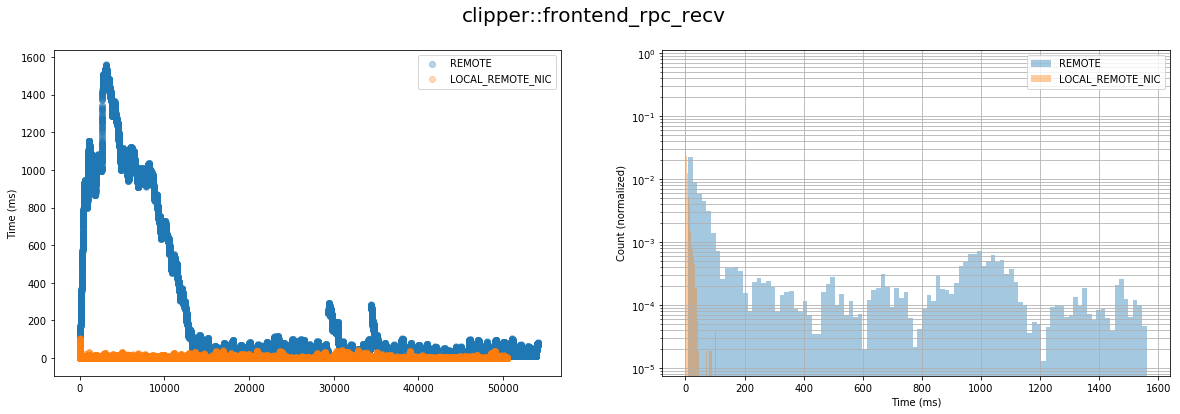

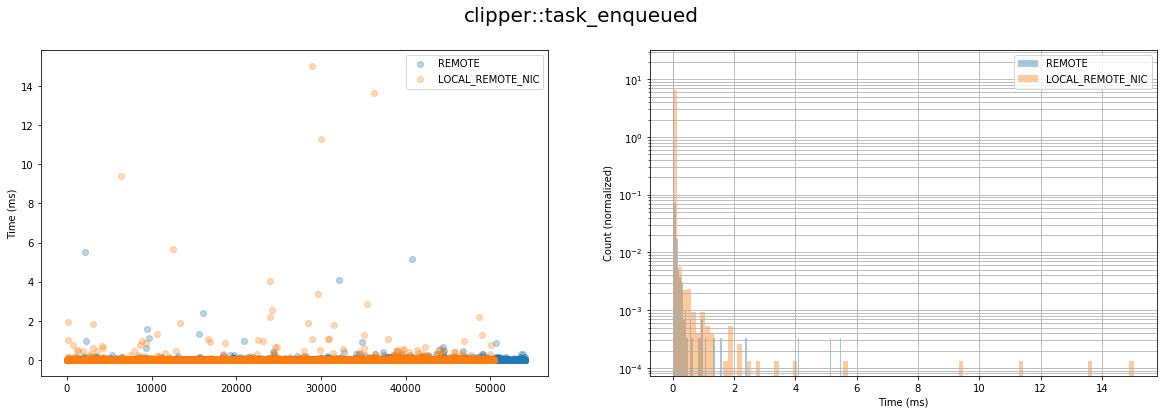

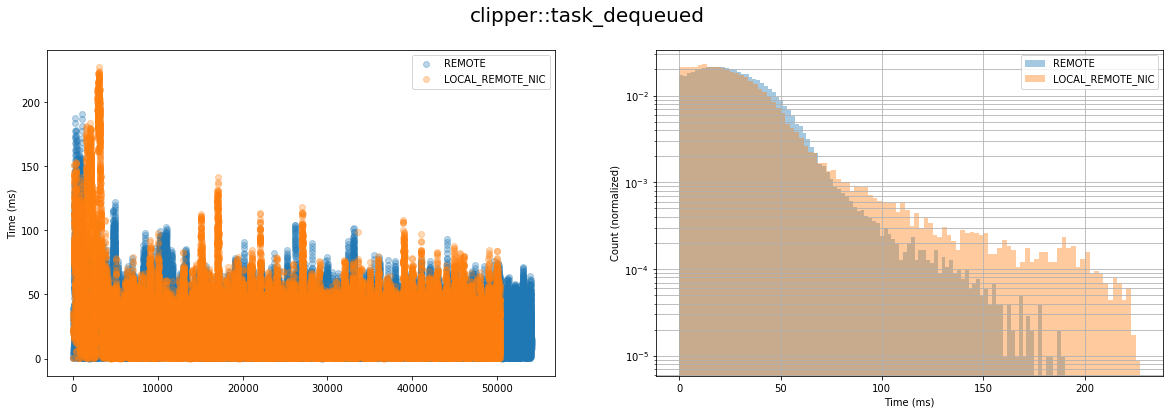

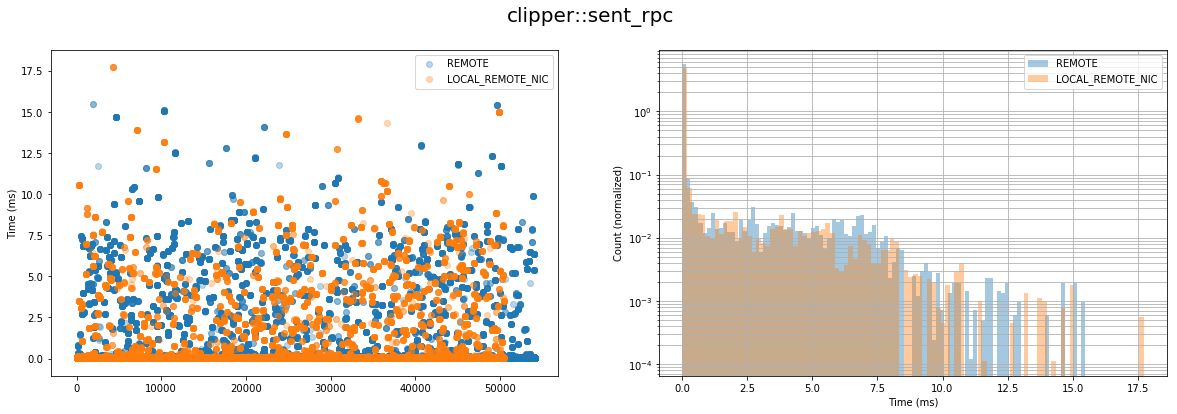

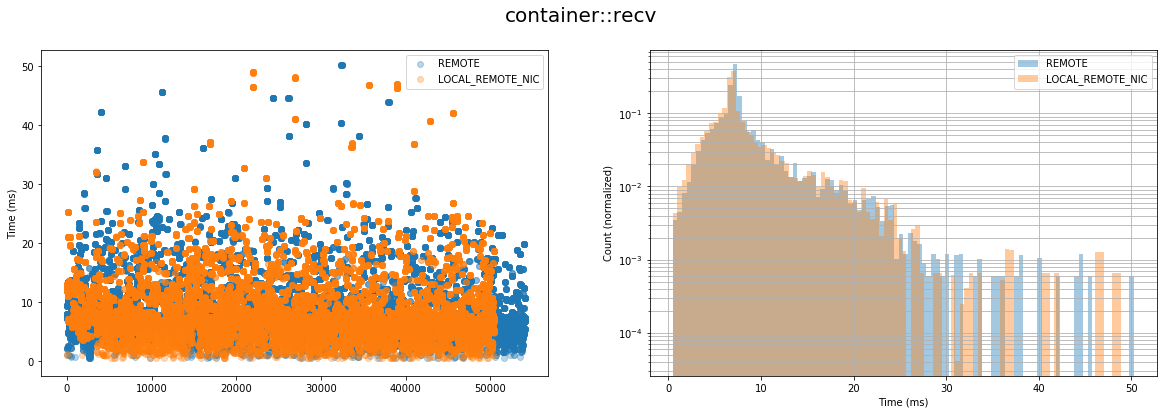

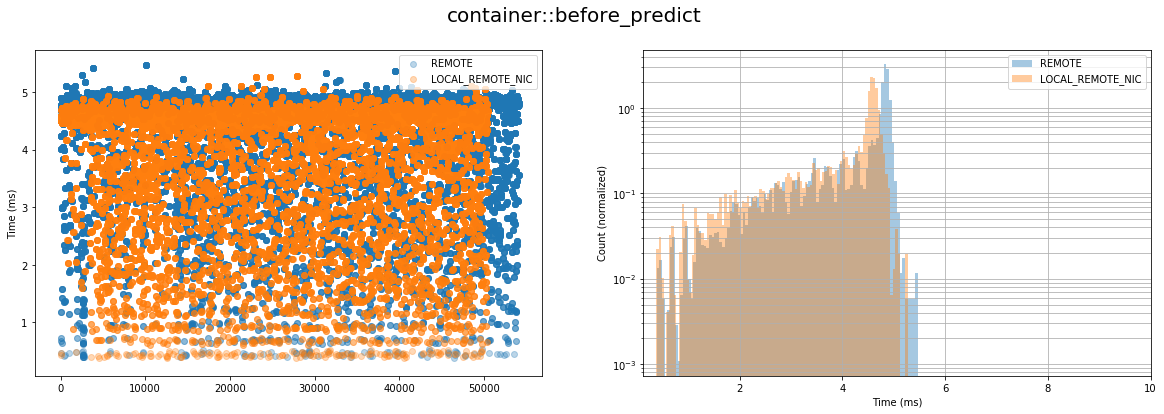

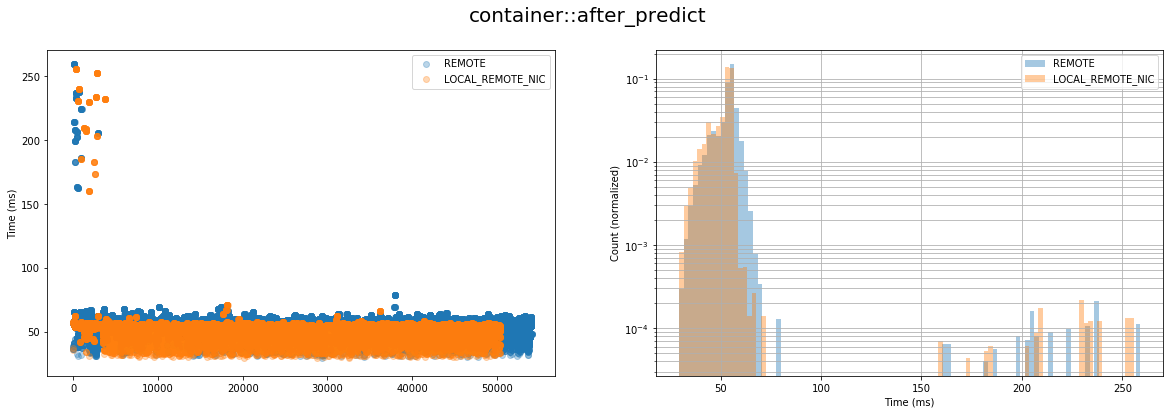

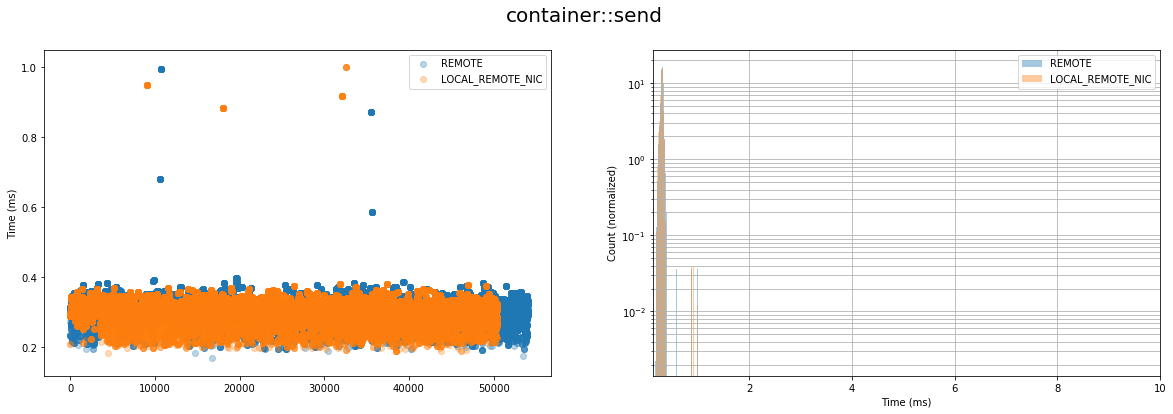

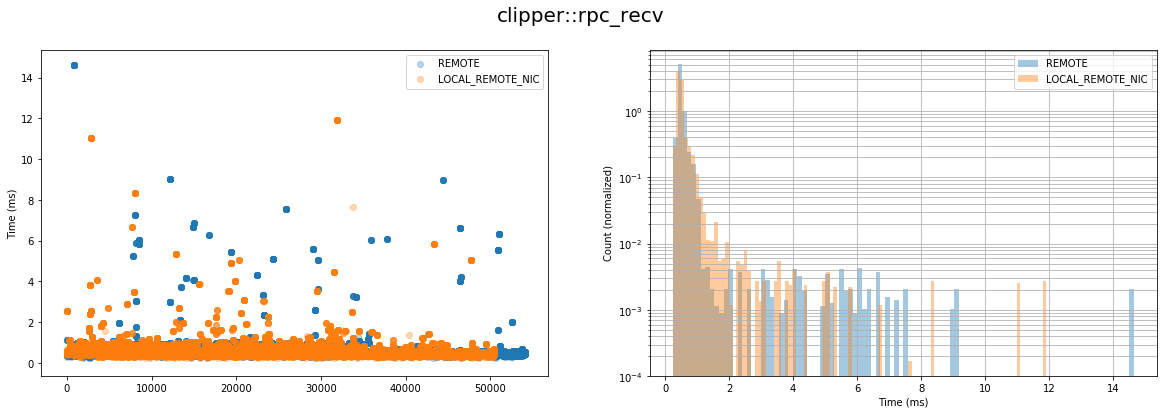

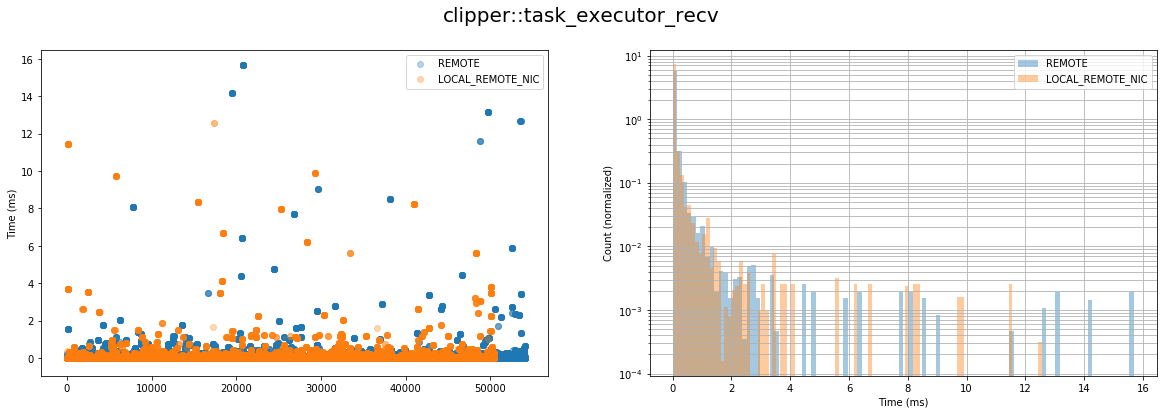

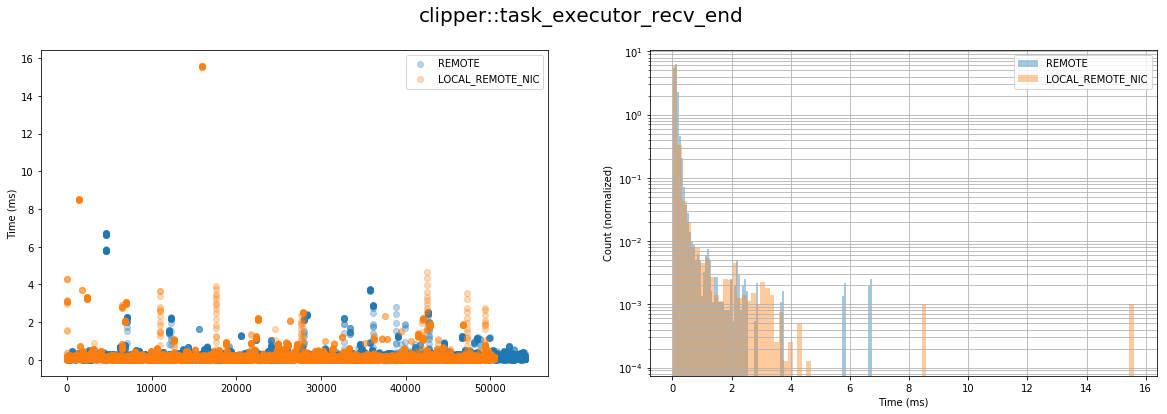

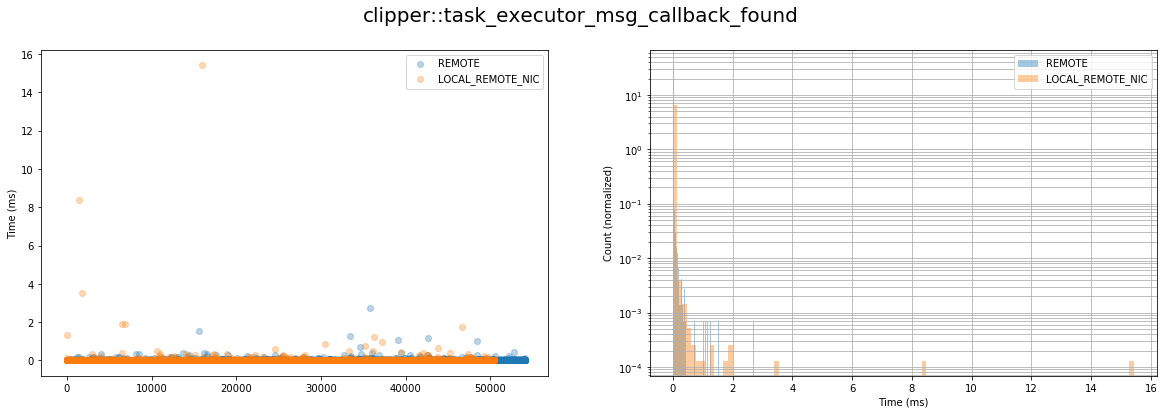

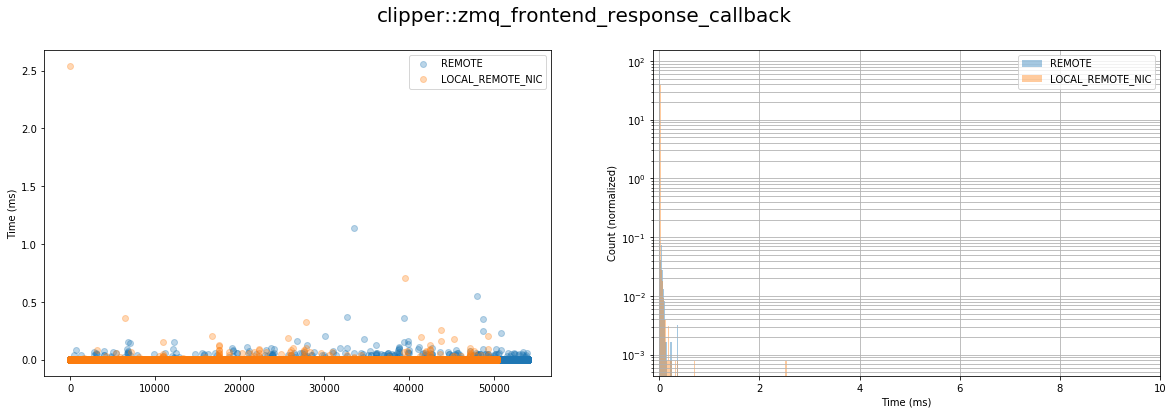

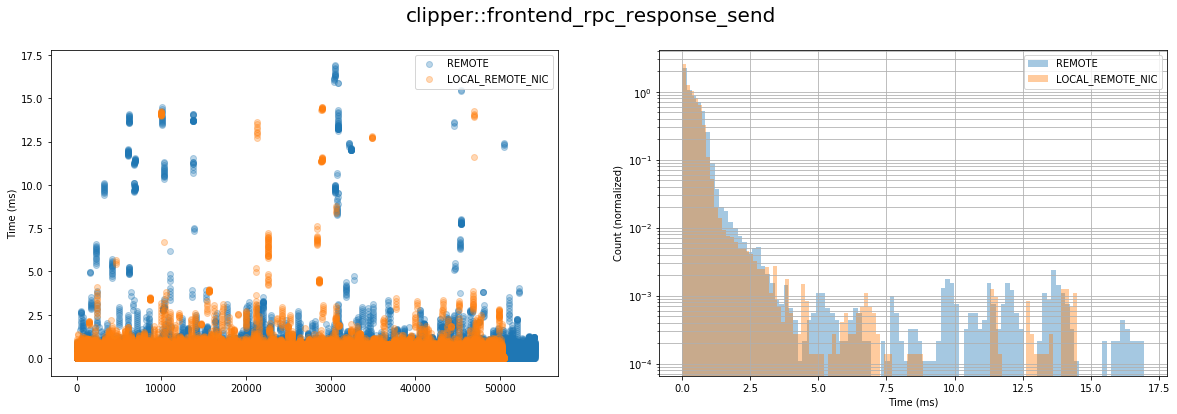

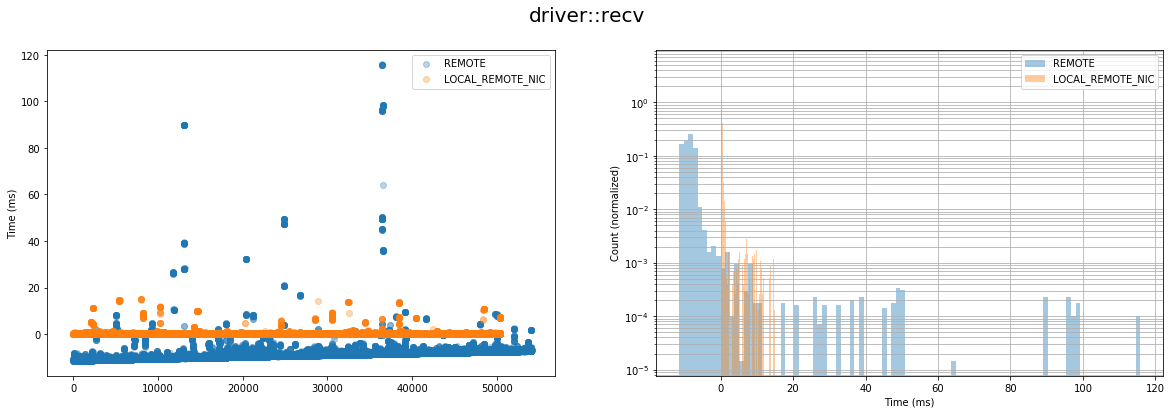

# Model: tf-kernel-svm

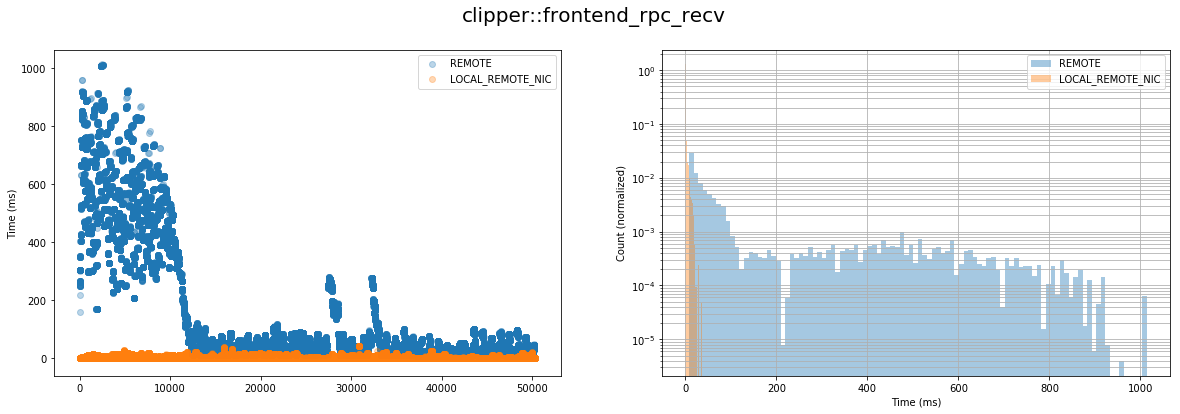

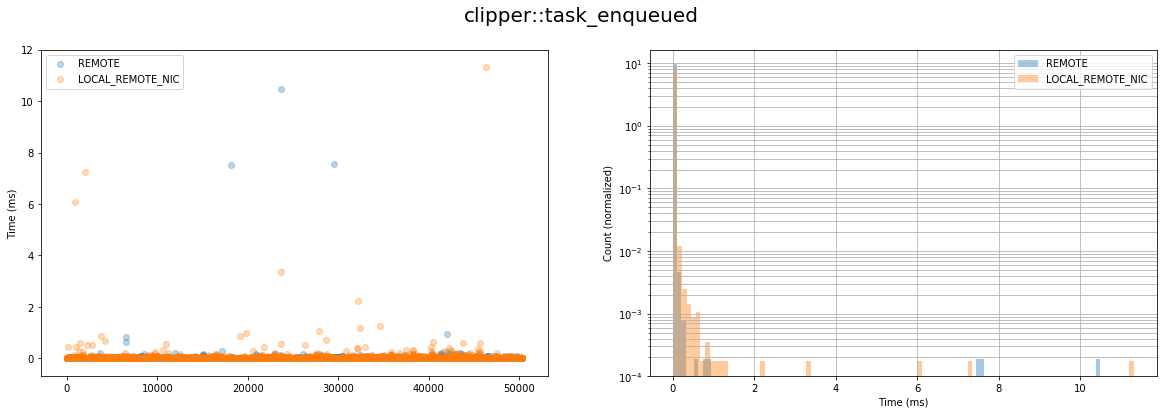

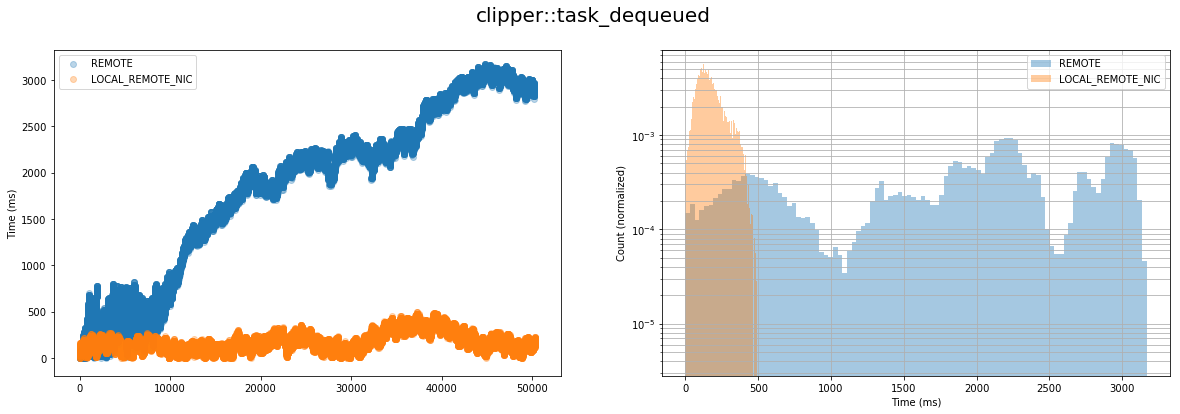

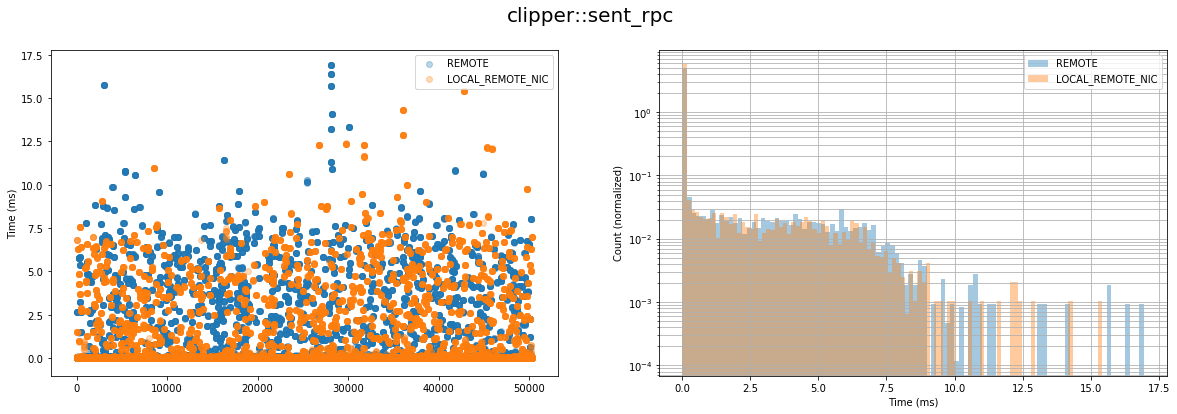

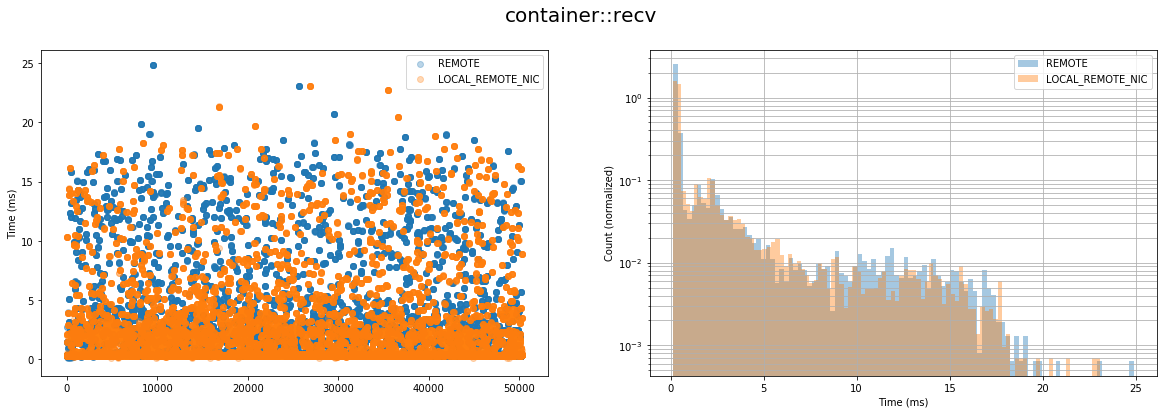

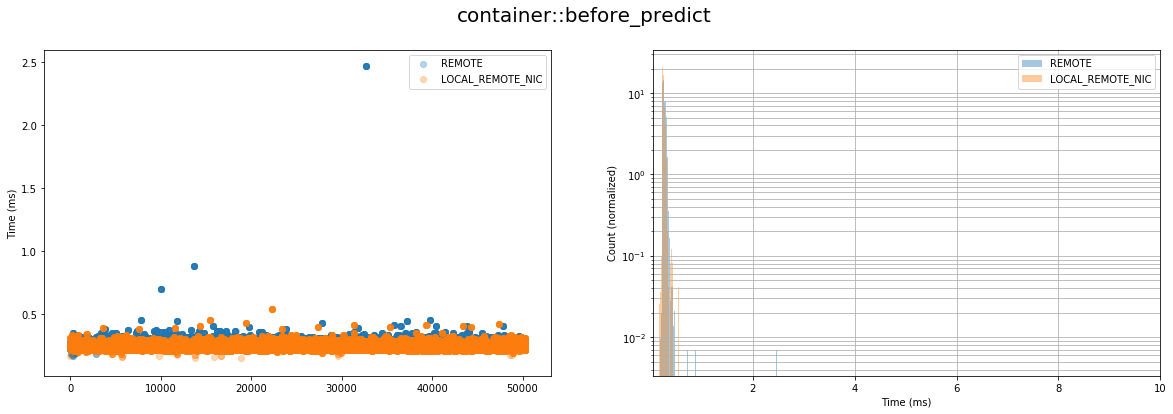

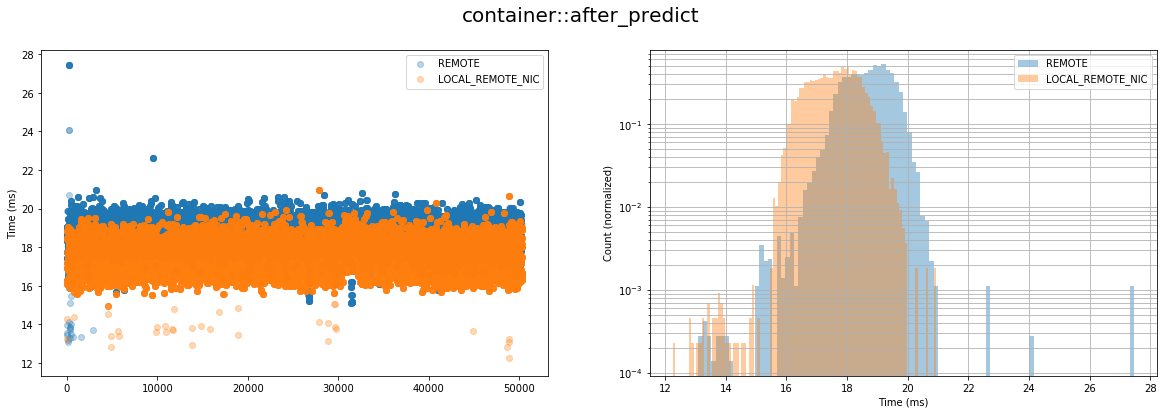

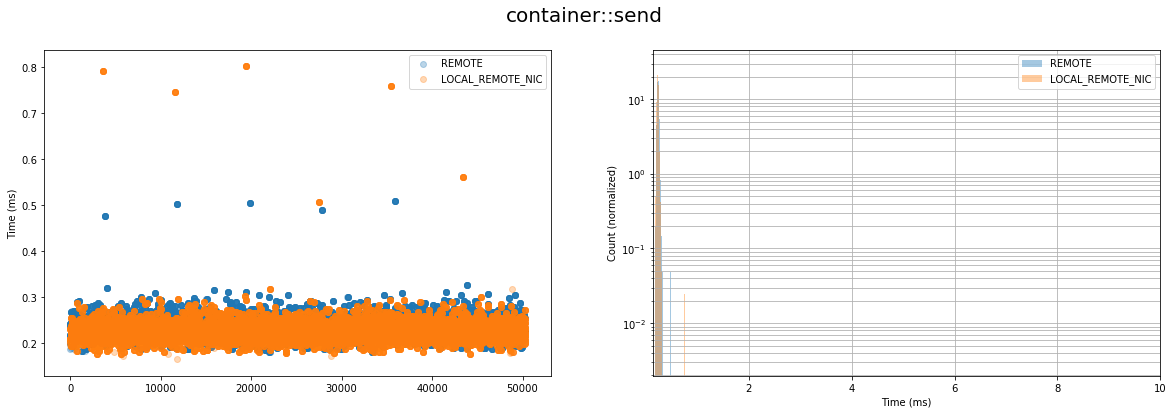

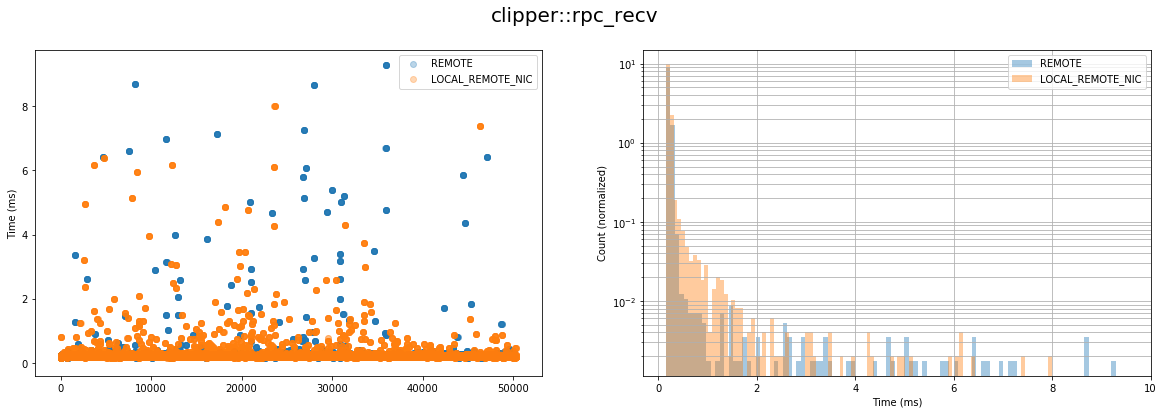

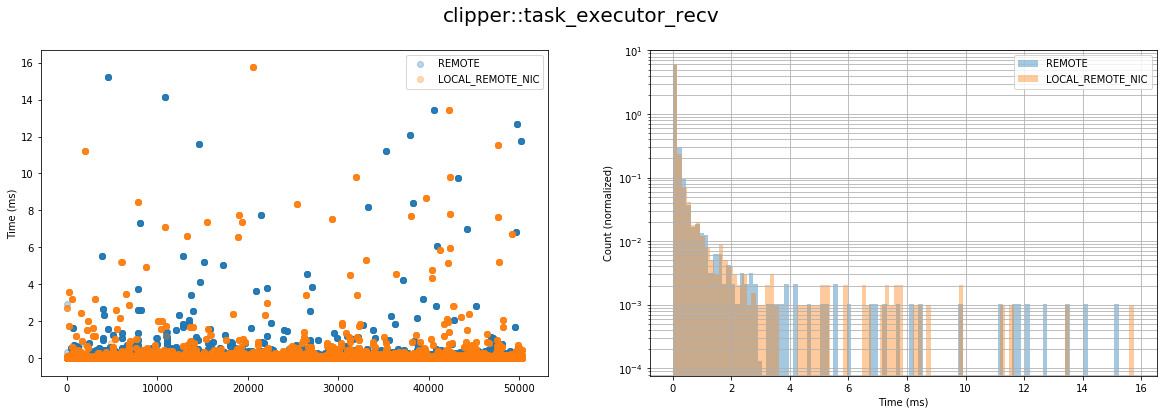

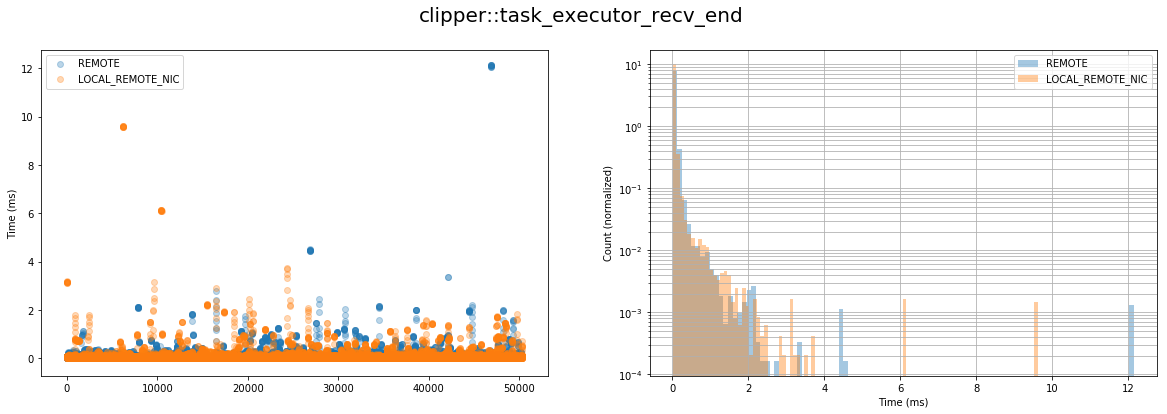

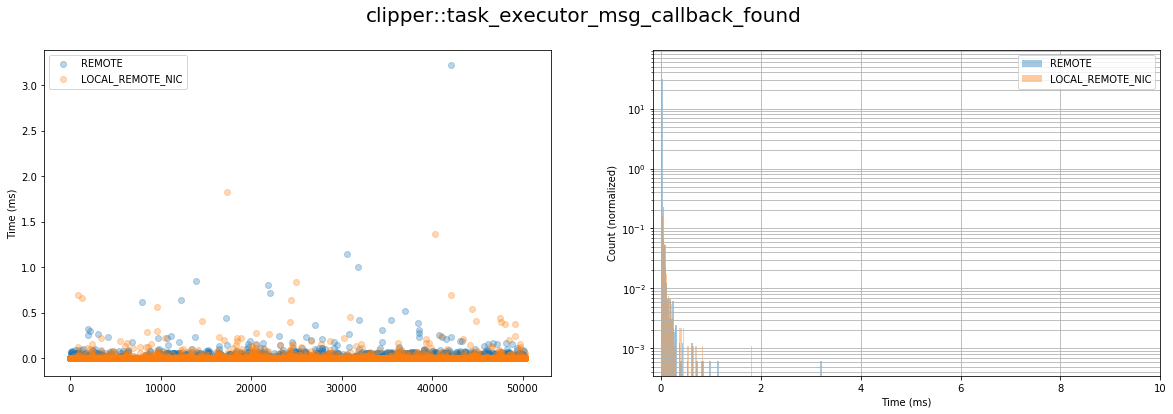

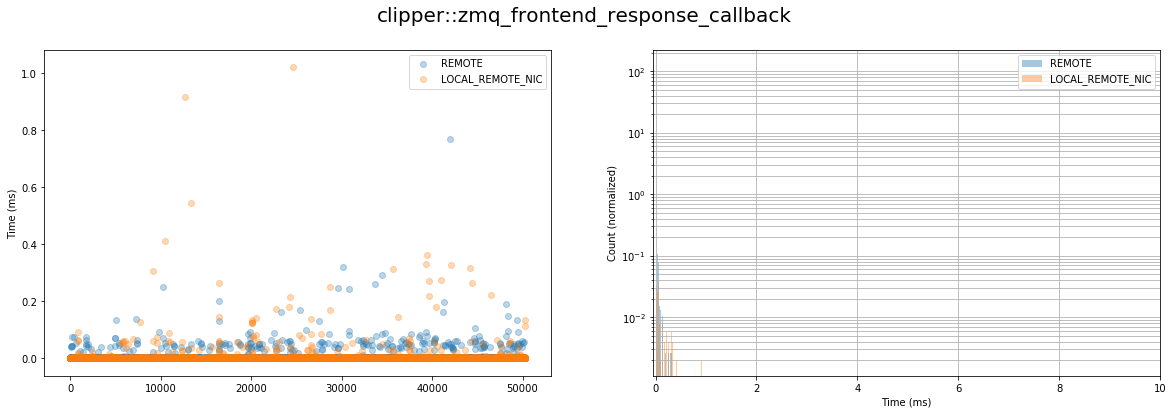

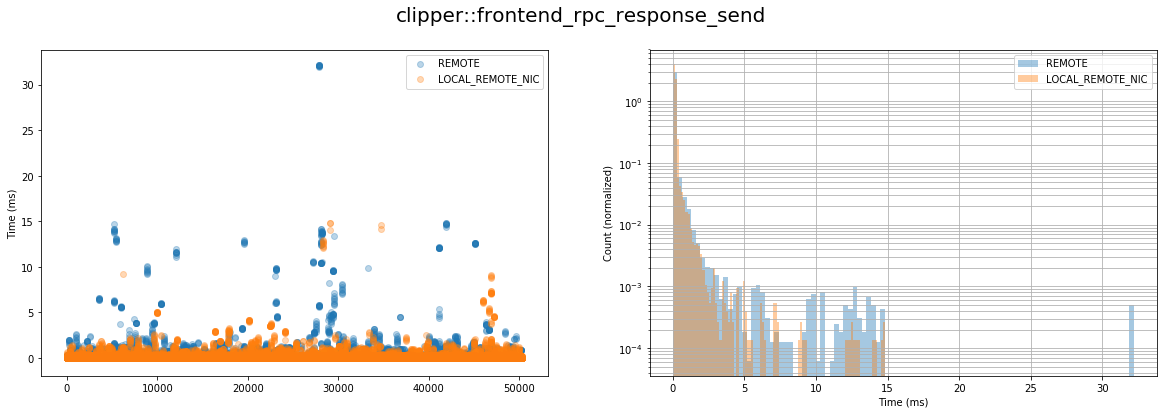

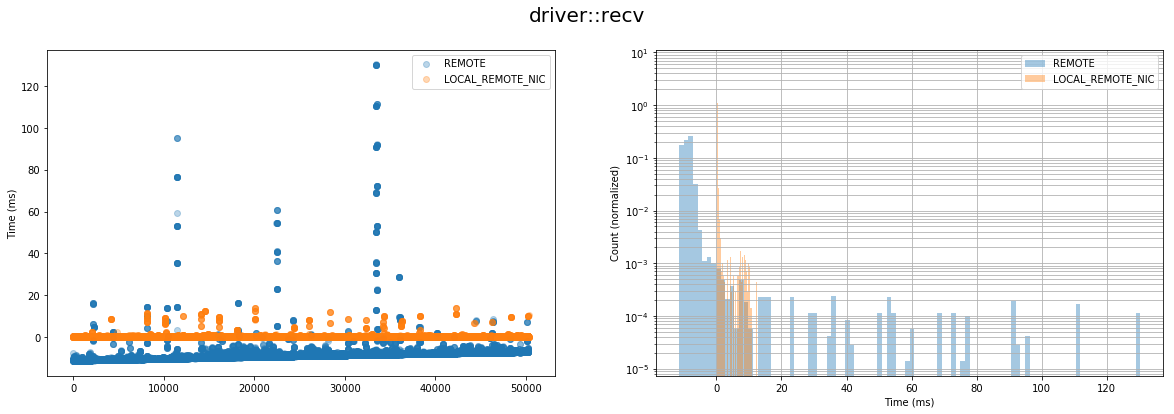

# Model: tf-resnet-feats

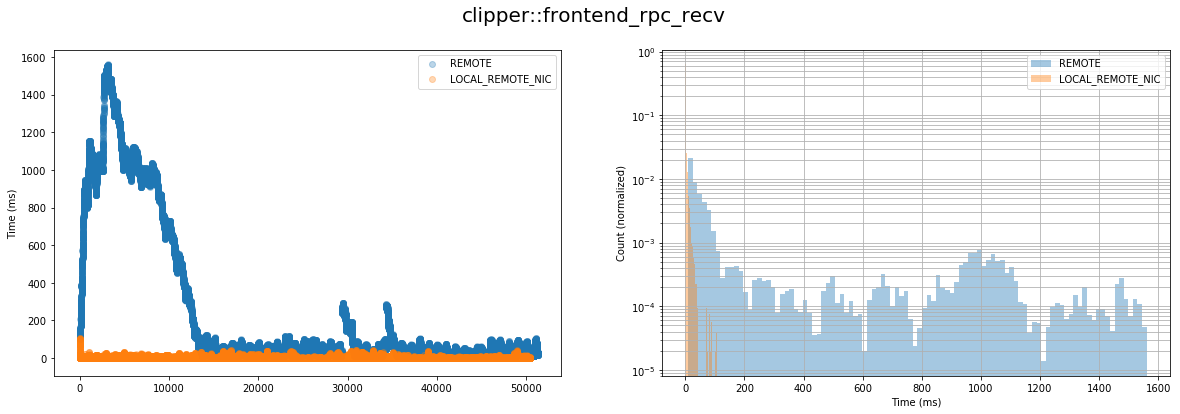

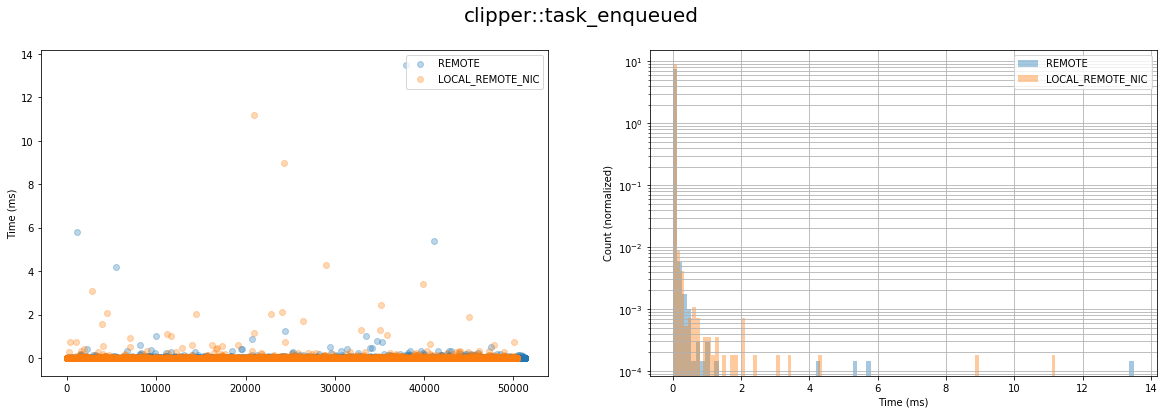

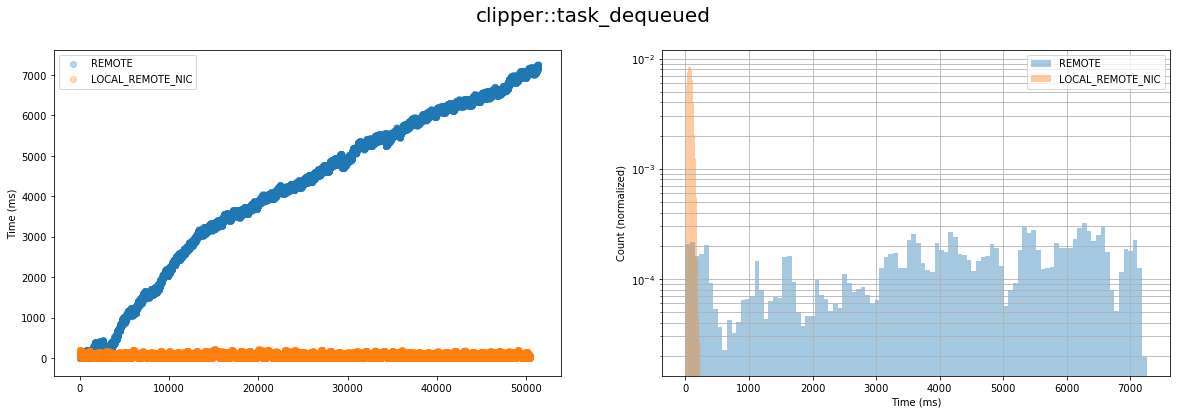

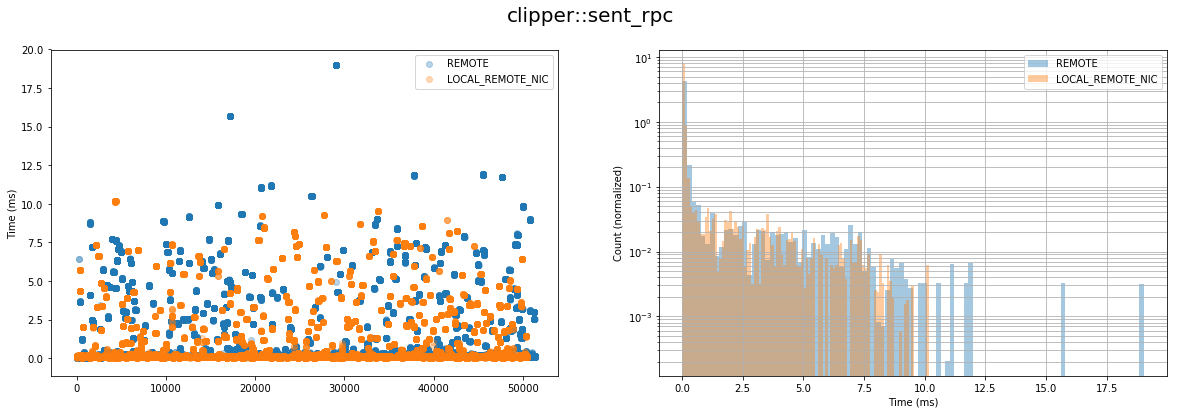

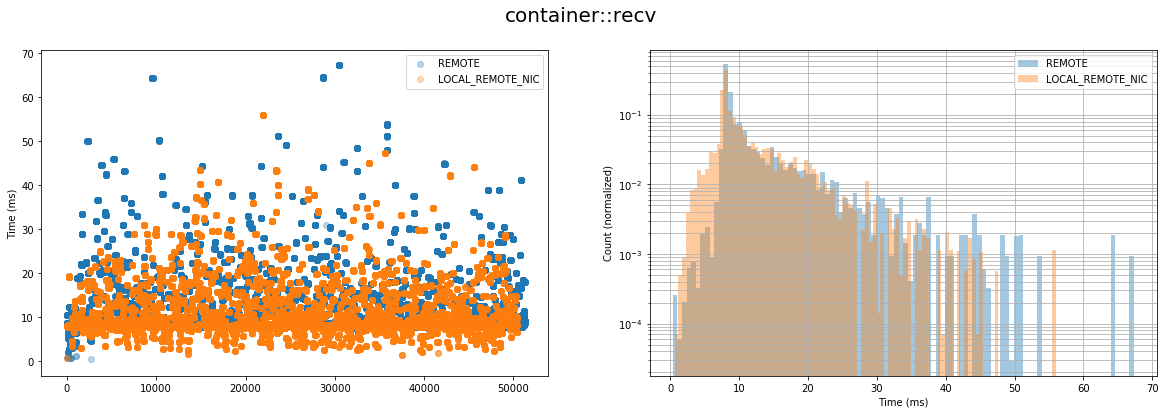

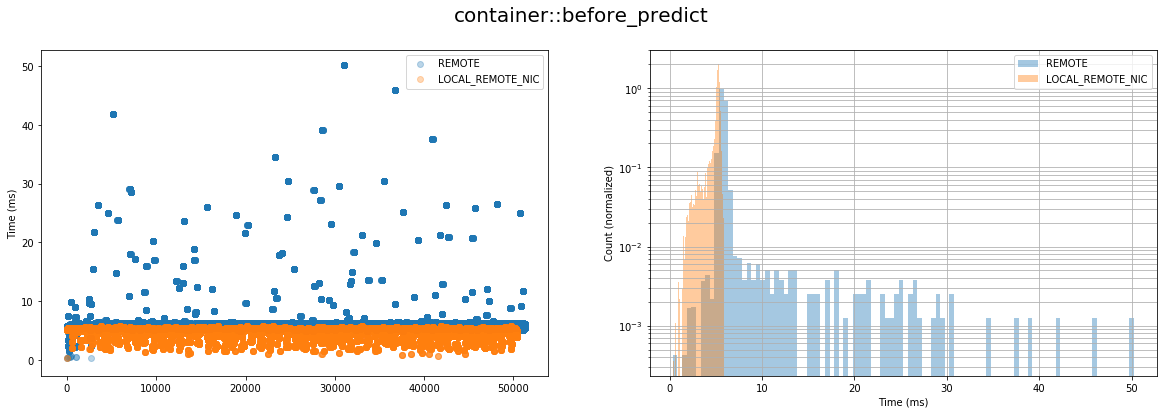

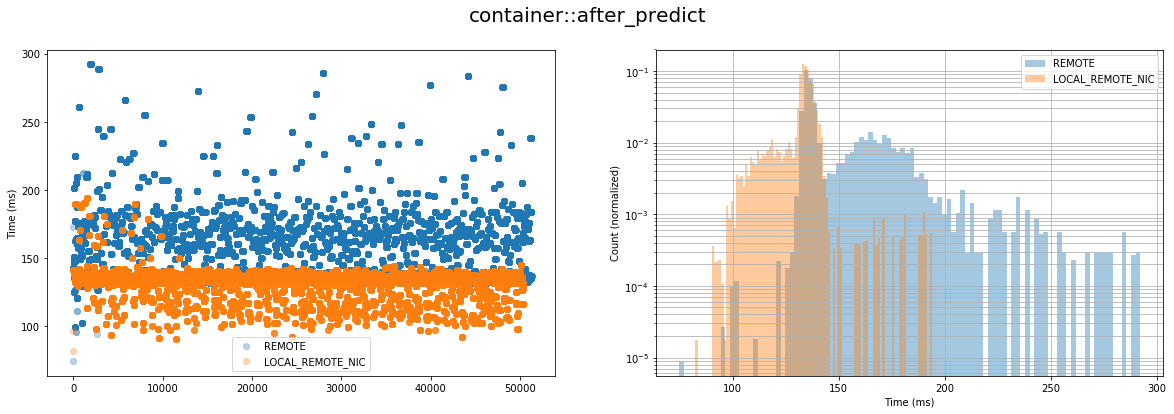

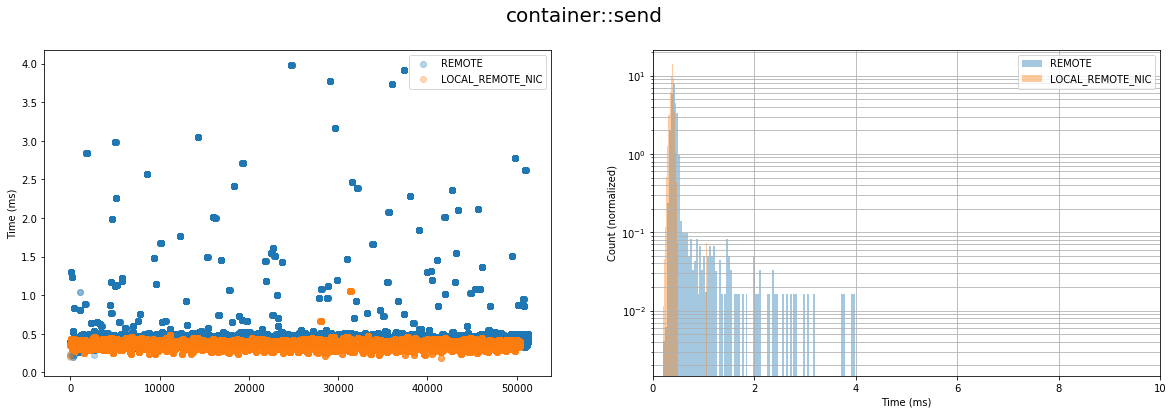

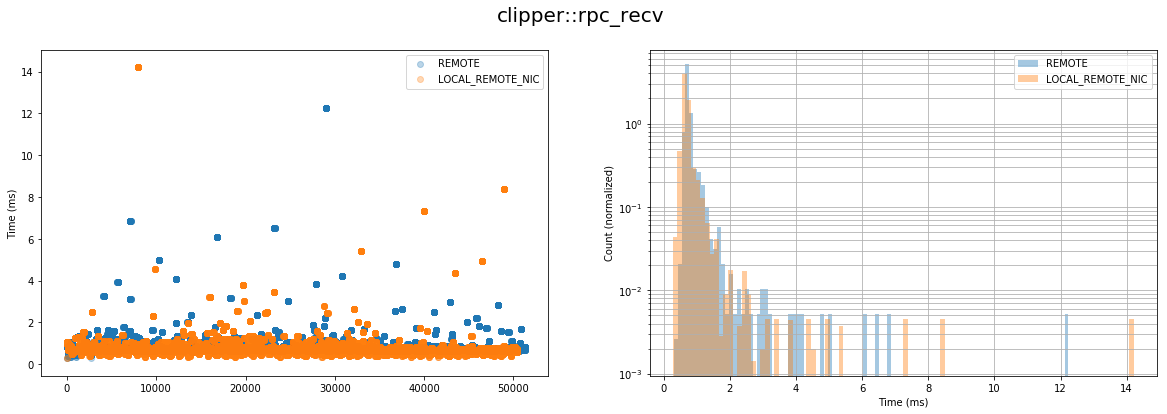

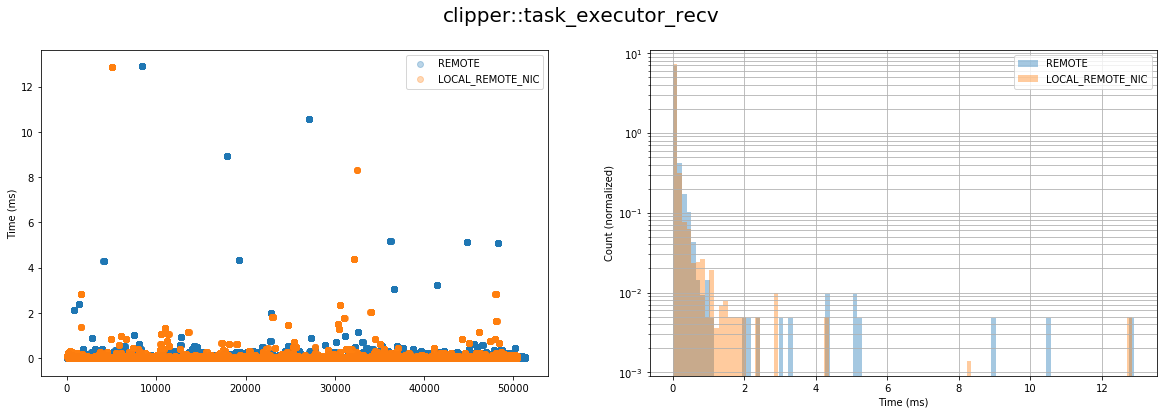

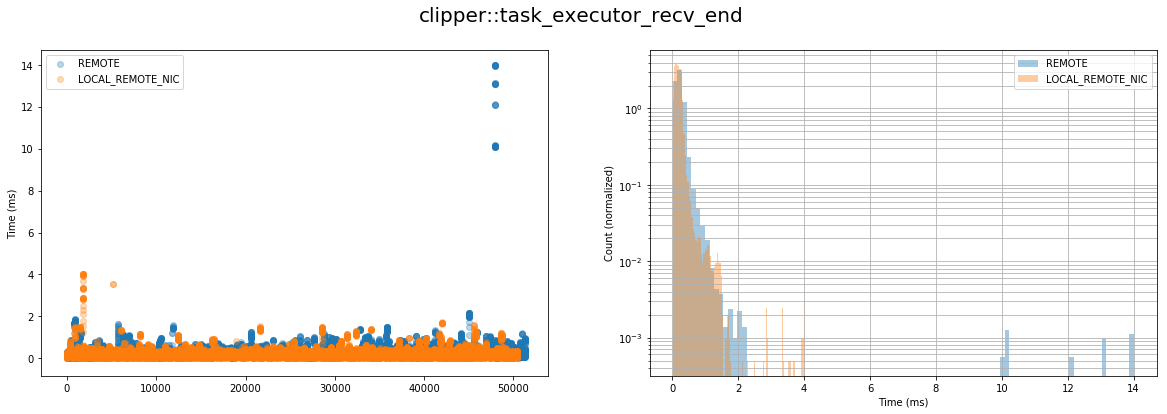

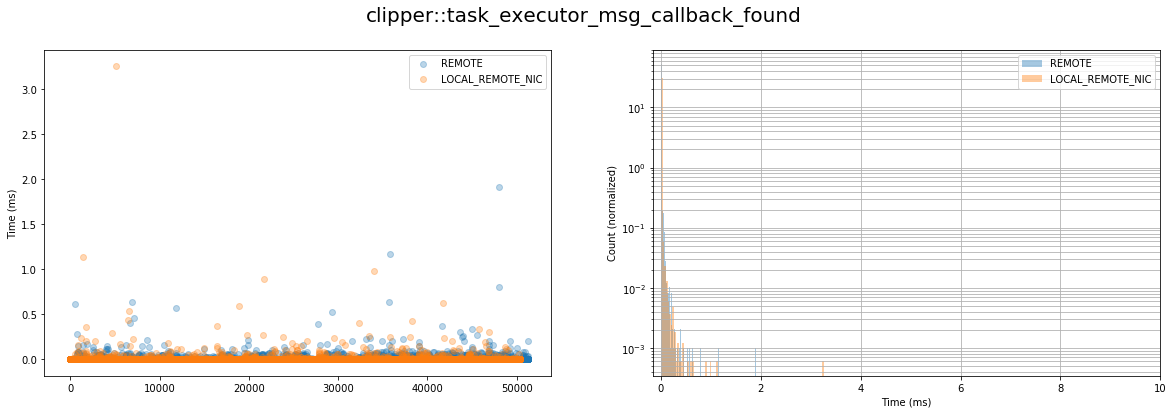

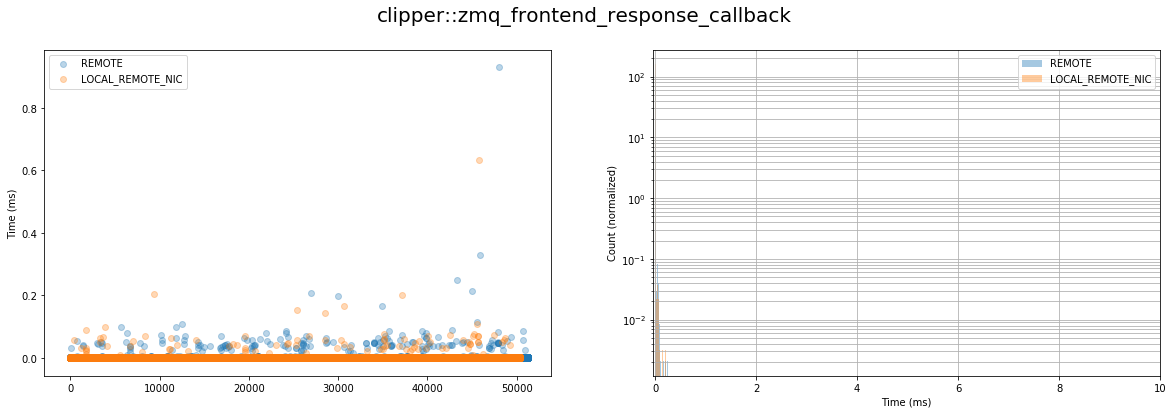

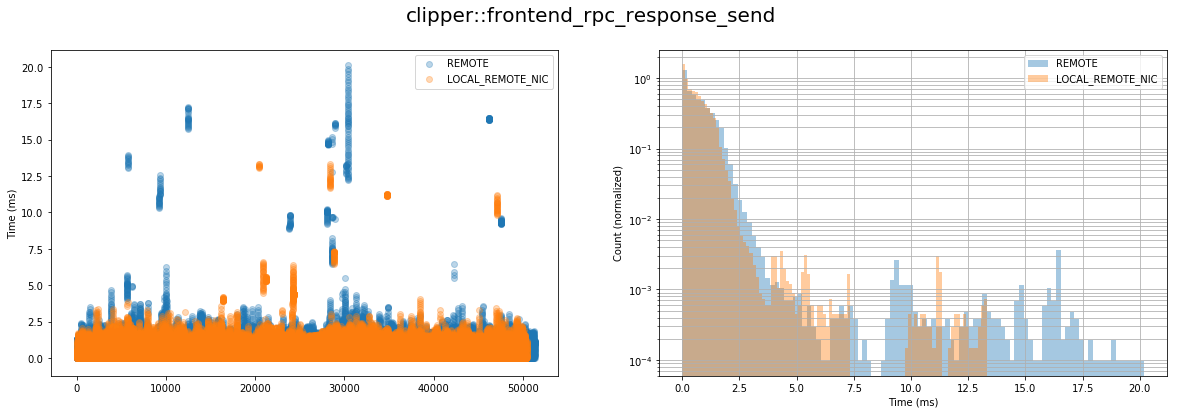

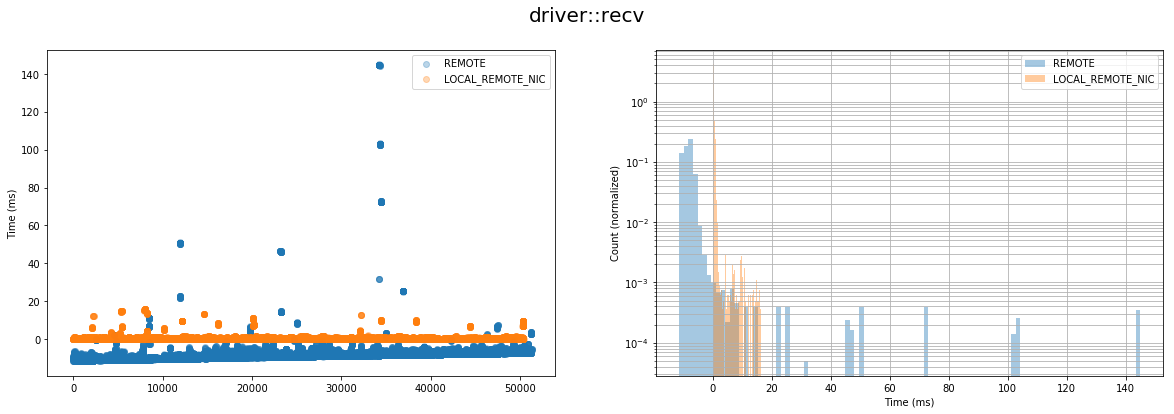

# Model: tf-log-reg

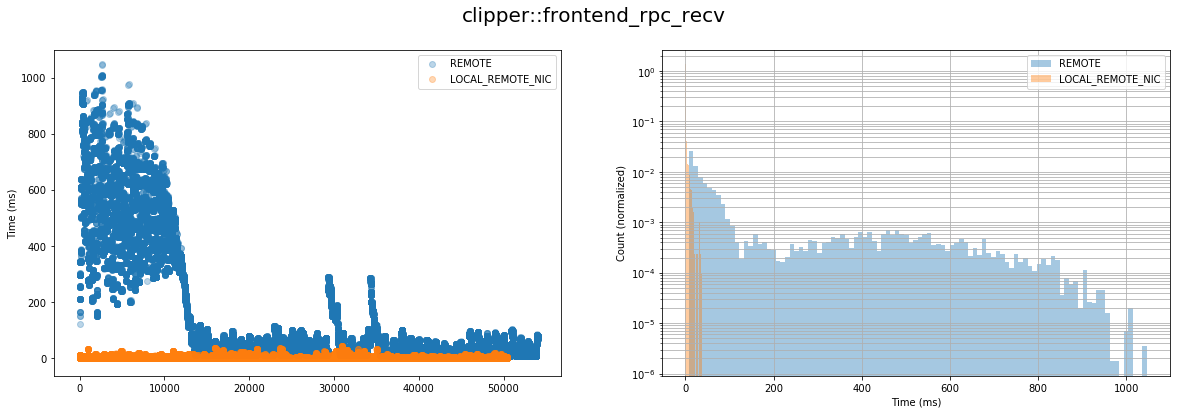

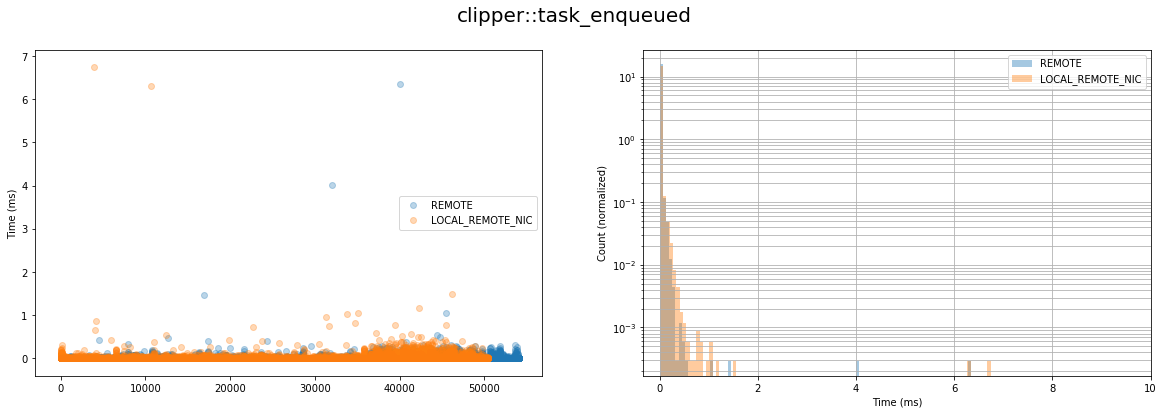

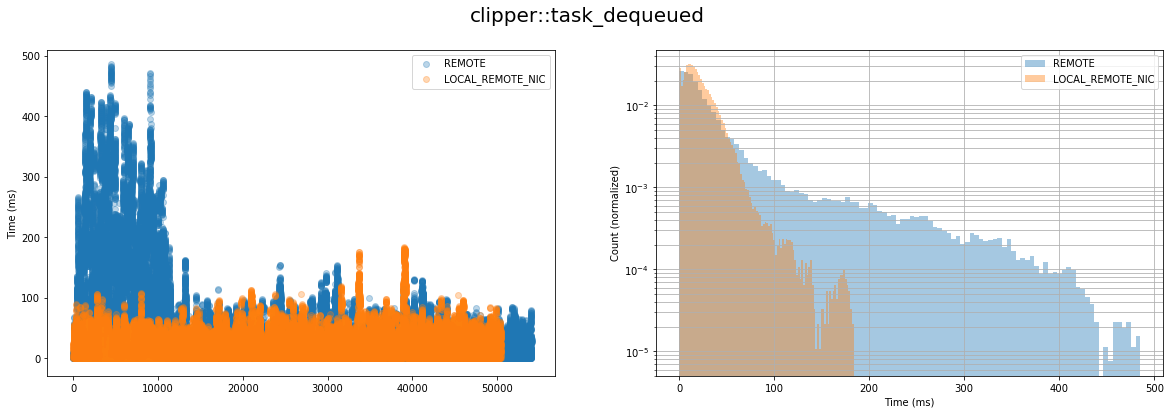

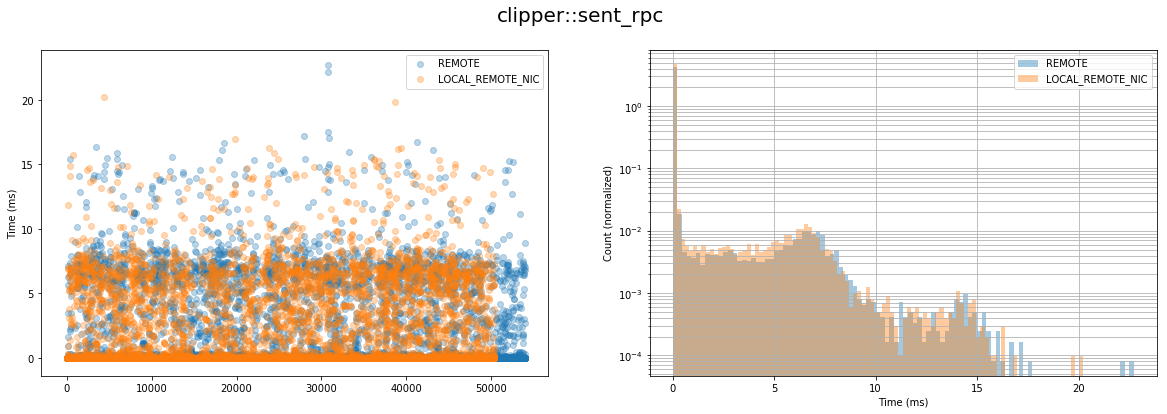

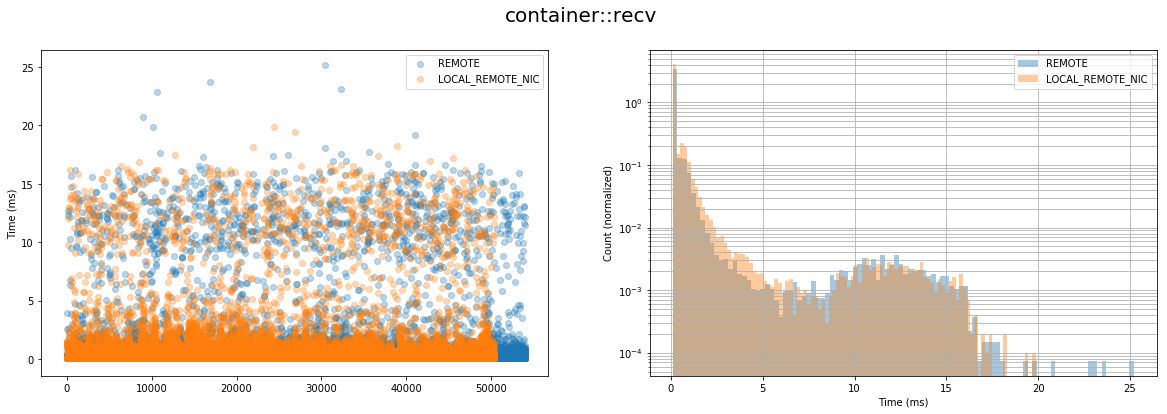

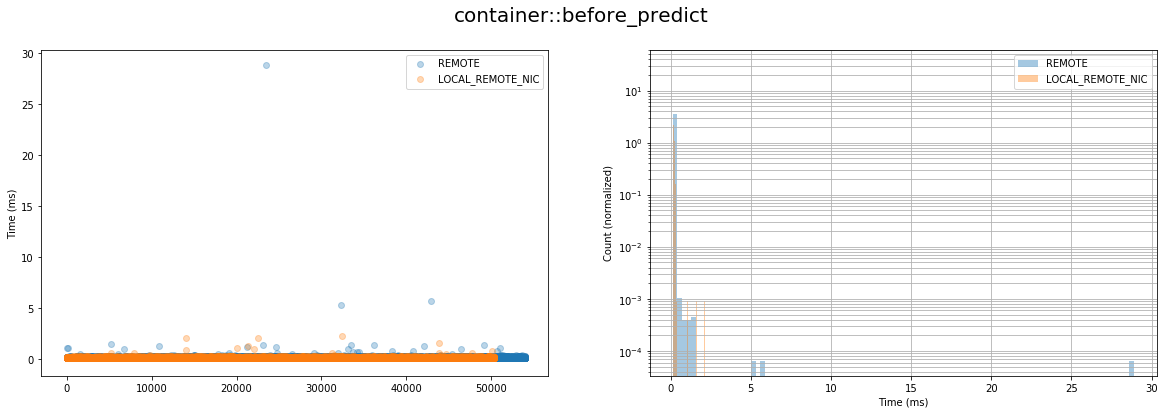

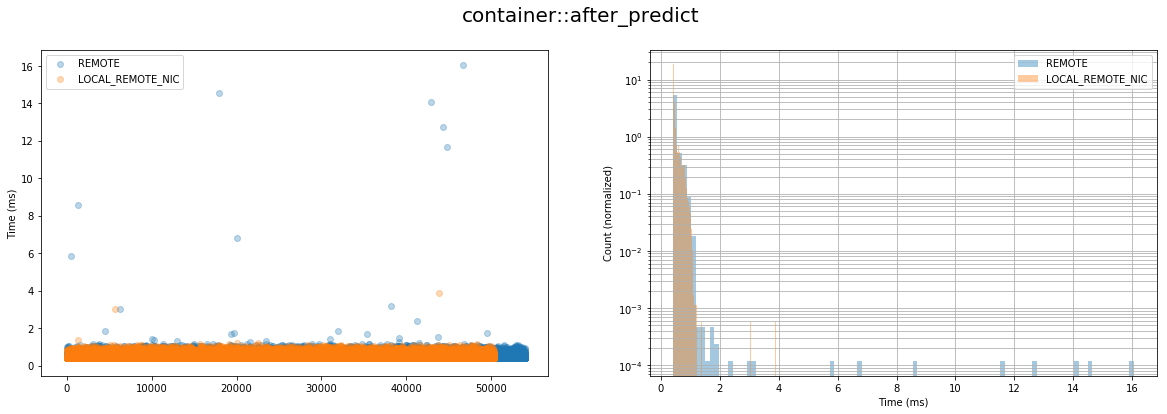

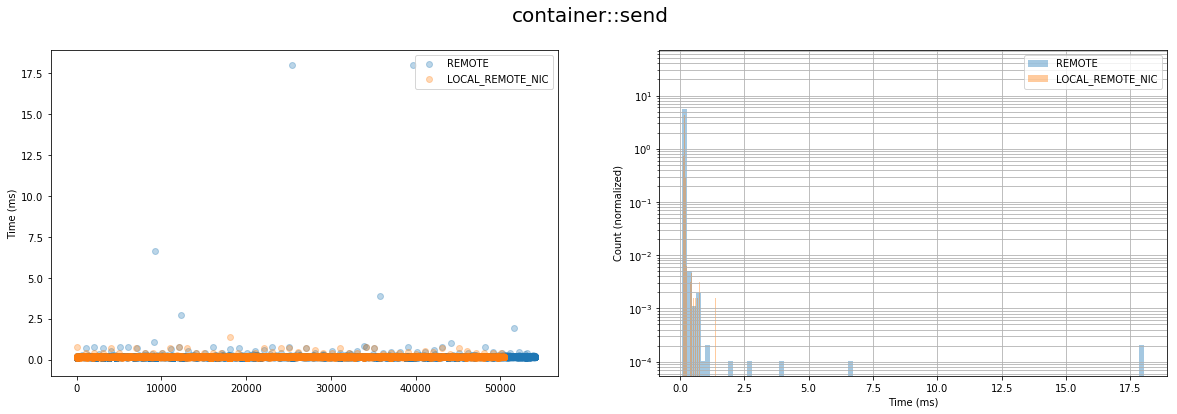

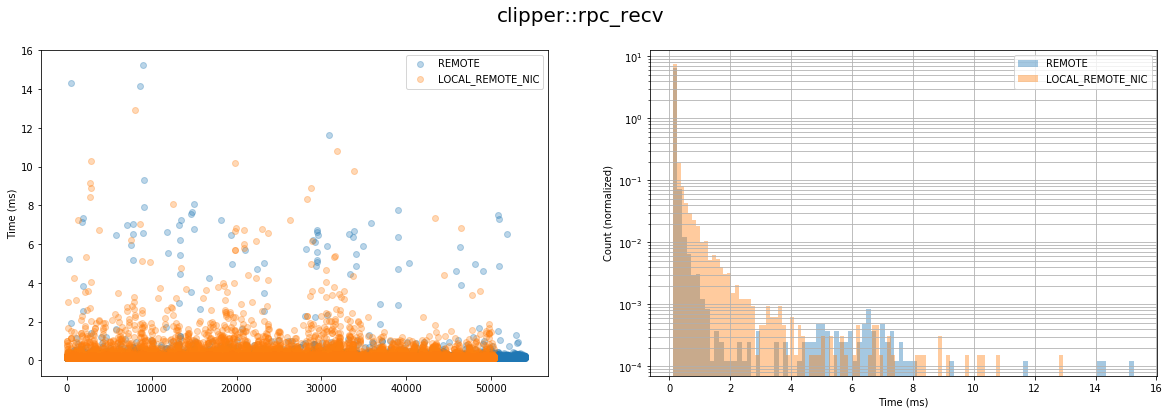

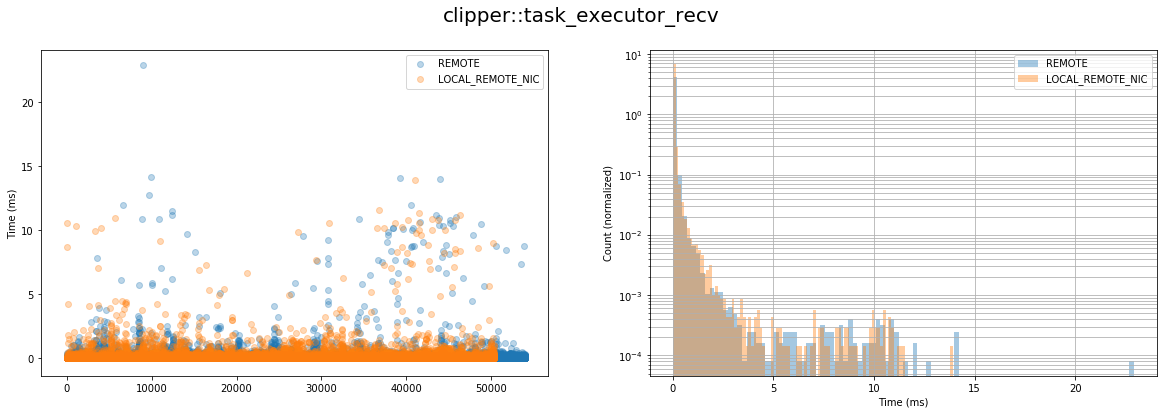

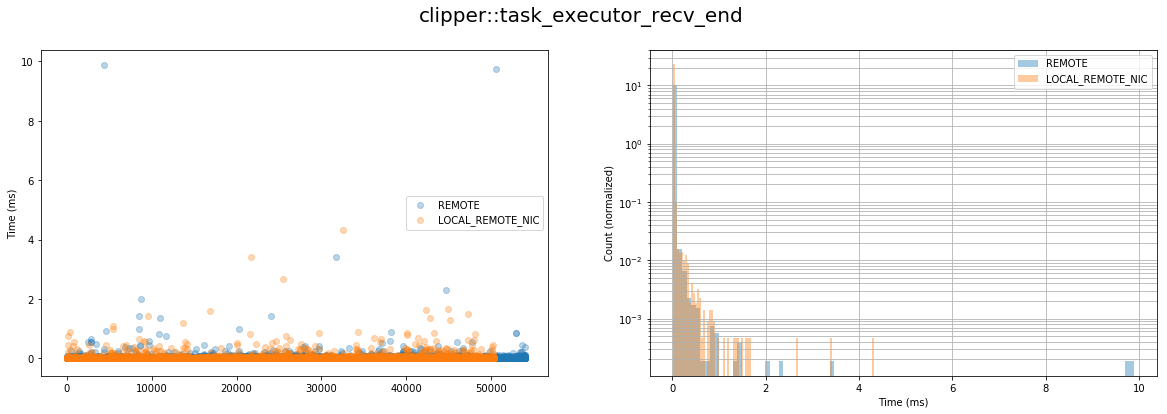

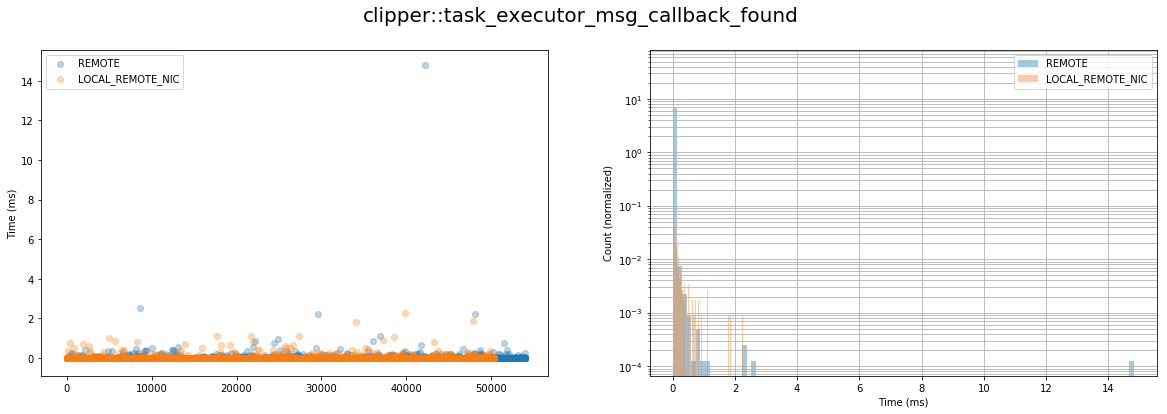

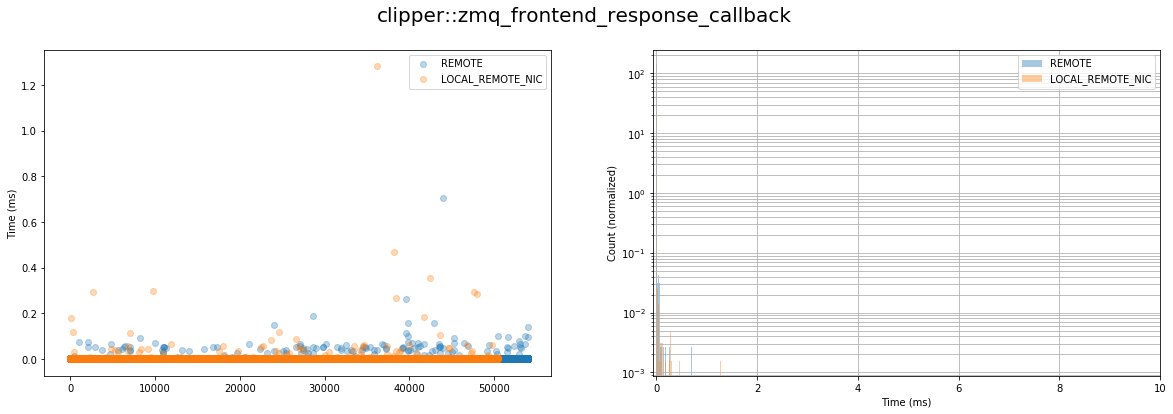

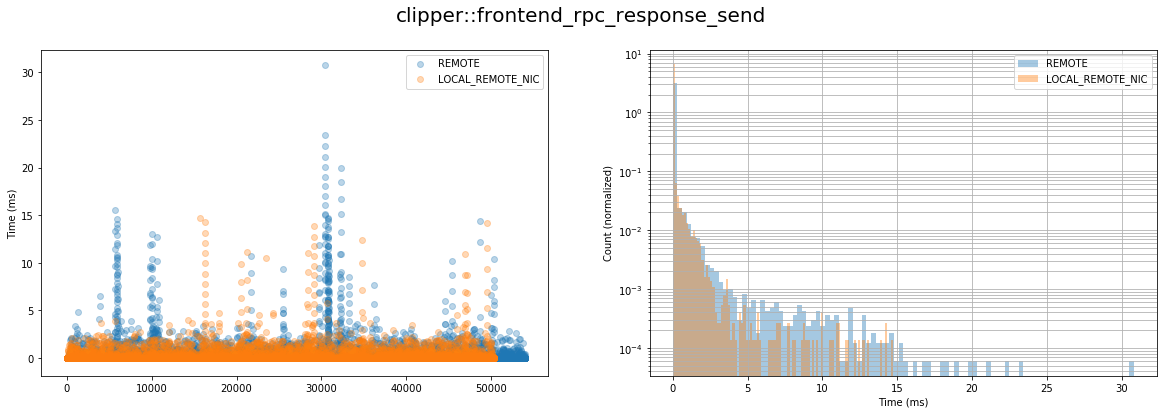

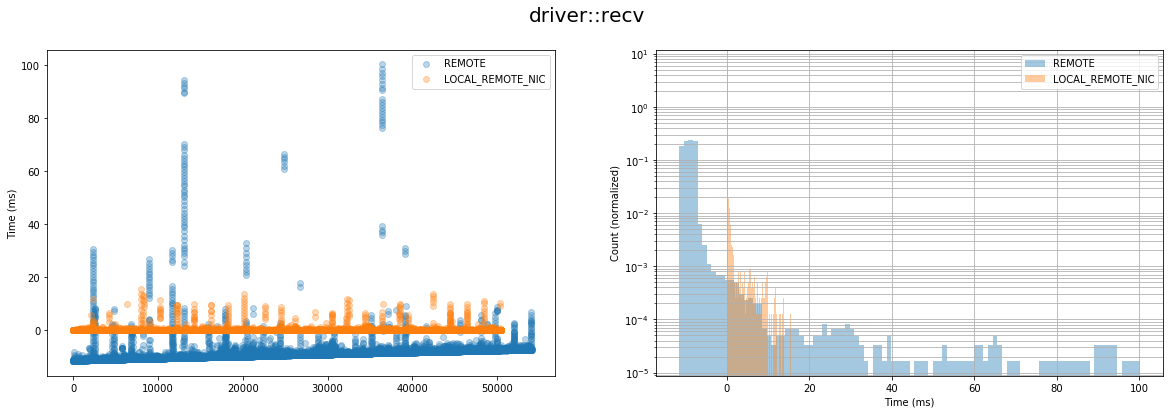

In [5]:
dir_path = "/Users/crankshaw/clipper-project/model-comp-project/plots-model-comp-paper/debugging/distributed_e2e_more_lineage/"
files = {}
for f in os.listdir(dir_path):
    
    name = f.split("_more_container")[0]
    name = name.split("_aws")[0]
#     if "NIC" not in name:
#         files[name] = os.path.join(dir_path, f)
    if not name == "LOCAL":
        files[name] = os.path.join(dir_path, f)

plots_dir = "remote_vs_local_plots"
analyze_lineage(files, plots_dir)

# Model: inception

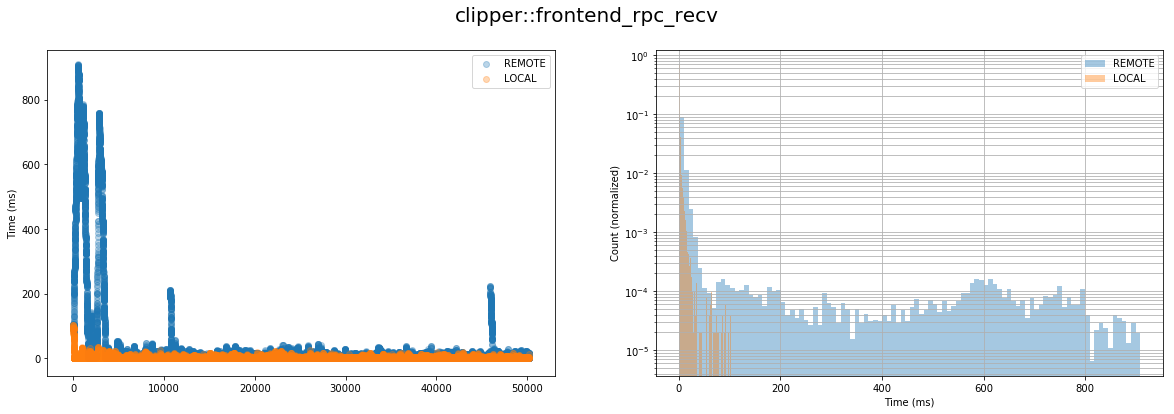

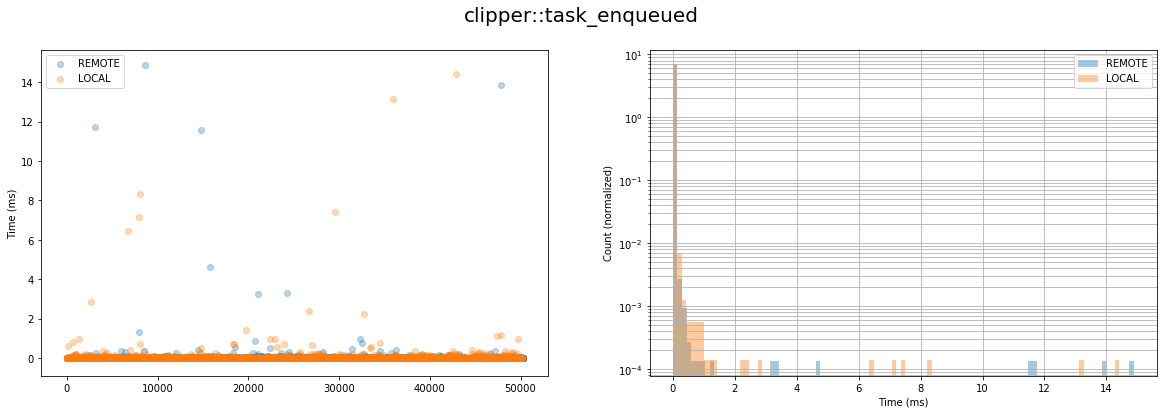

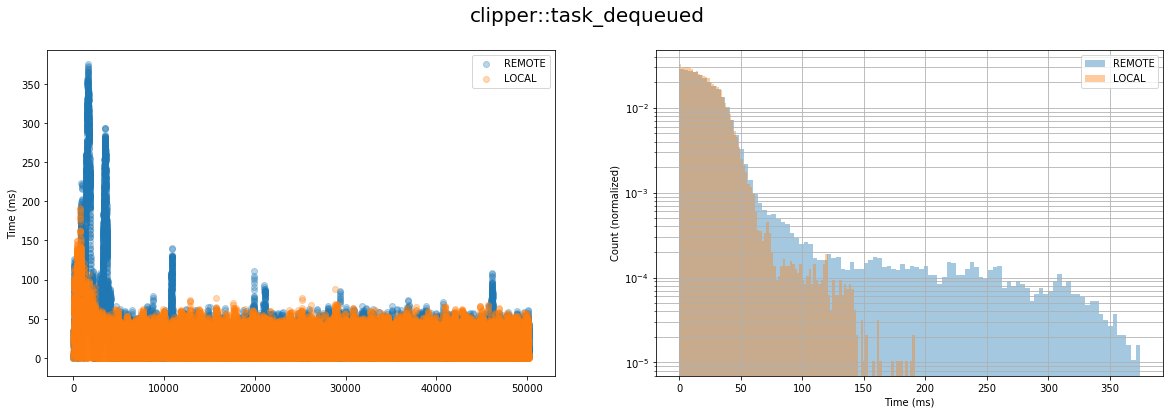

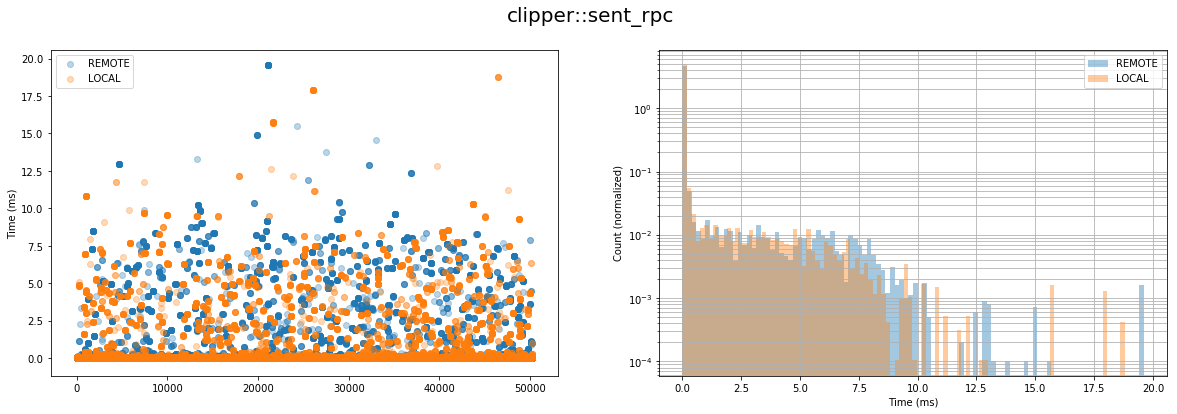

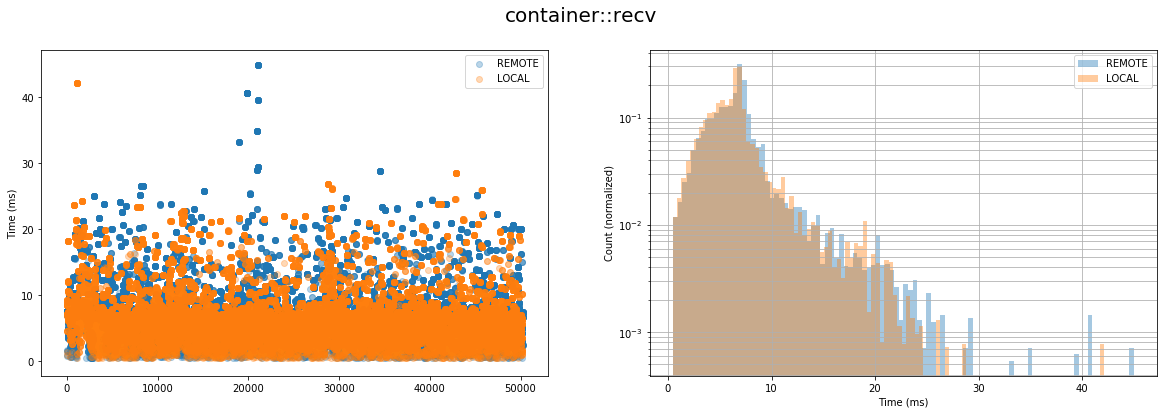

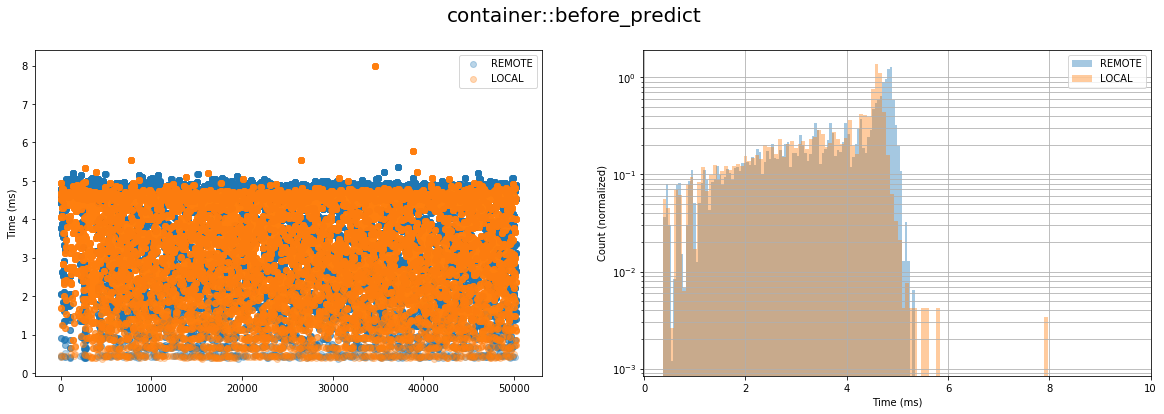

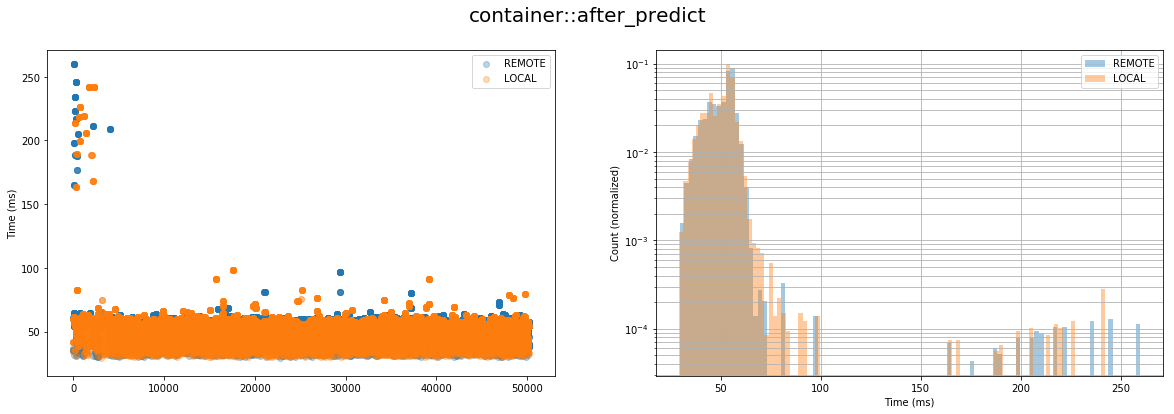

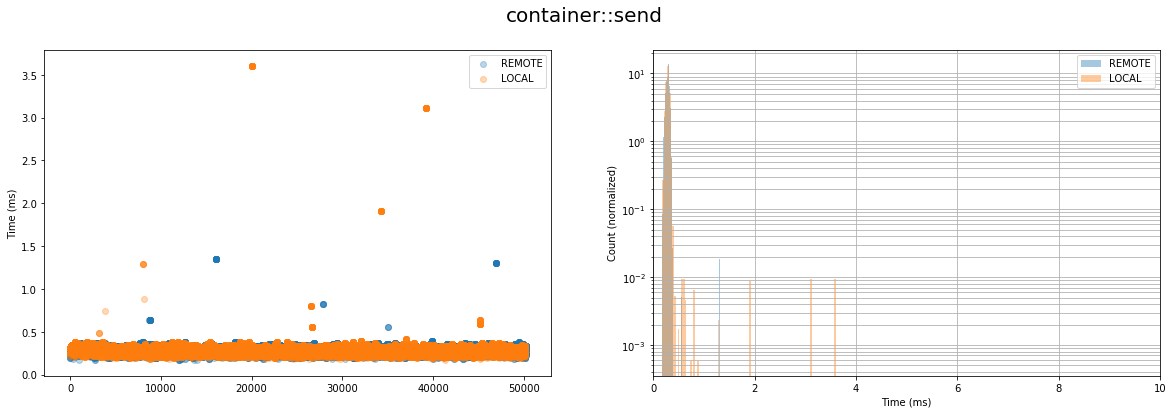

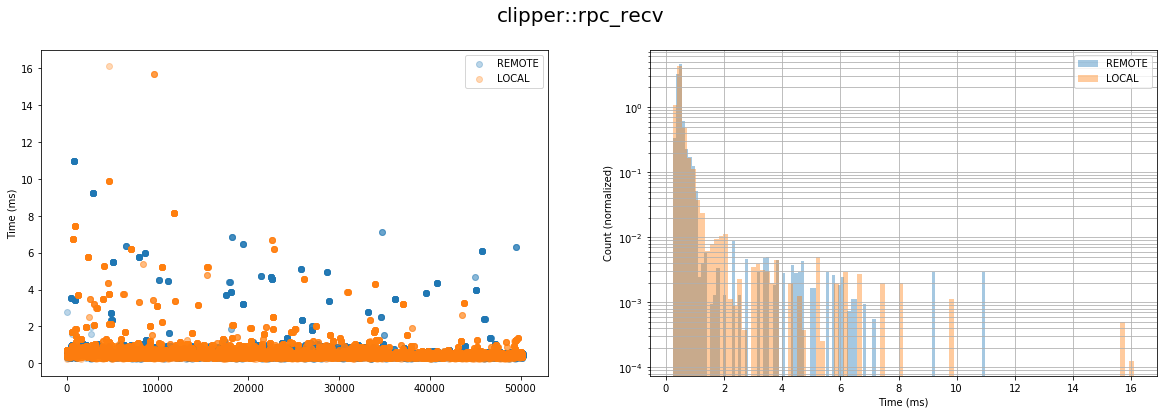

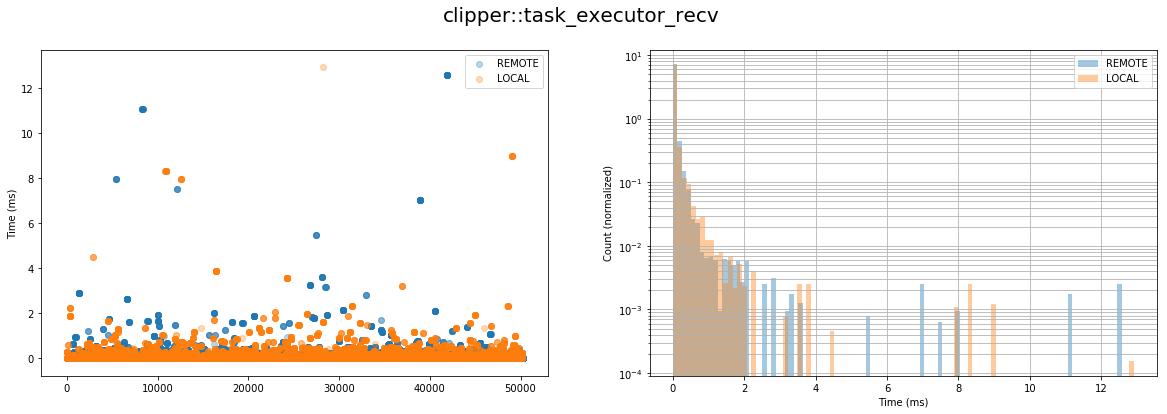

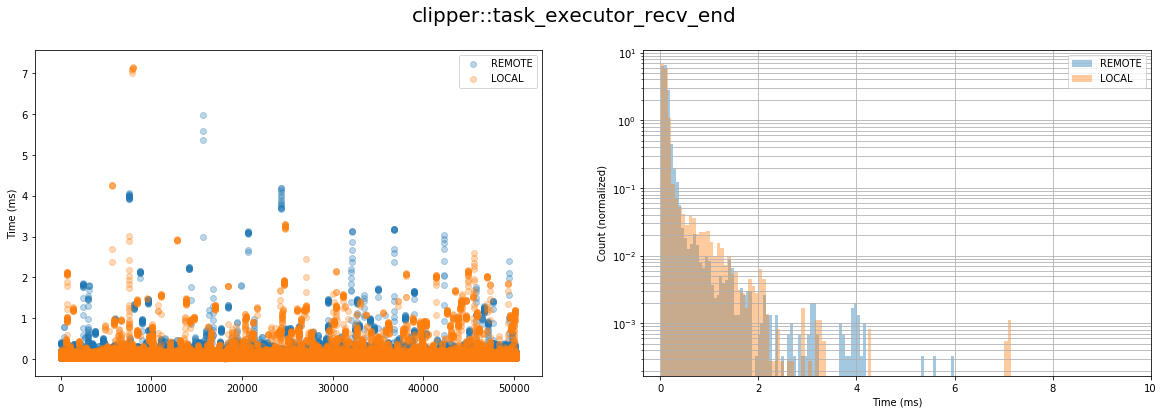

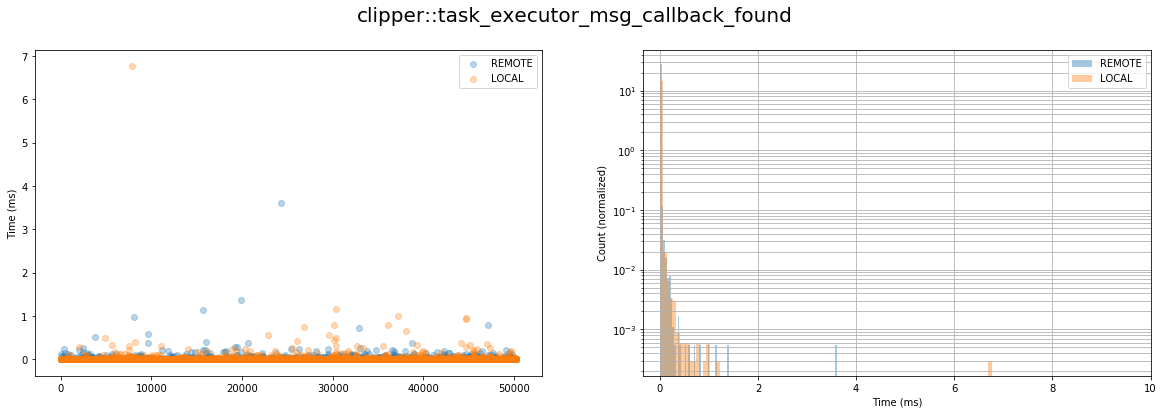

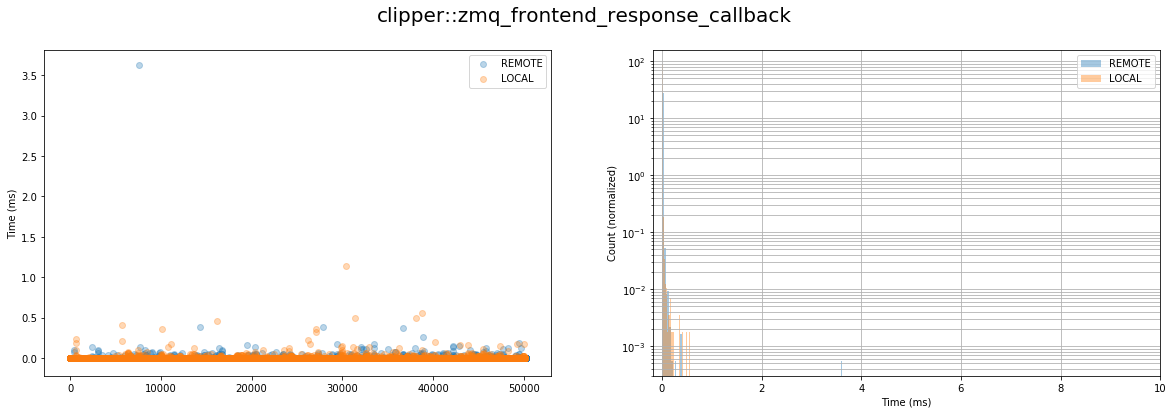

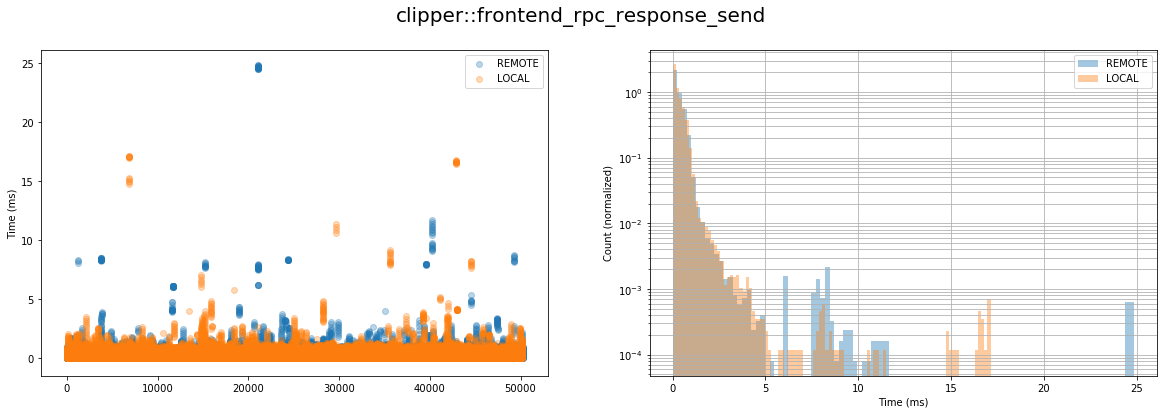

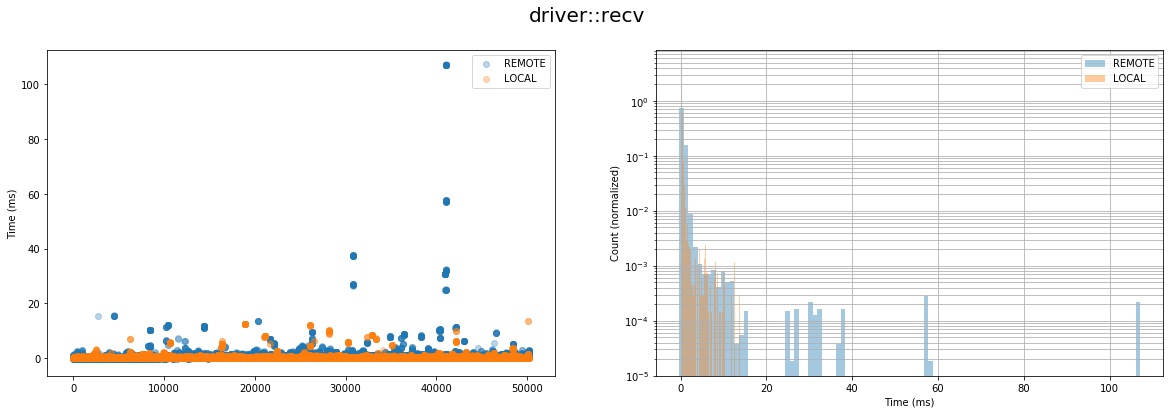

# Model: tf-kernel-svm

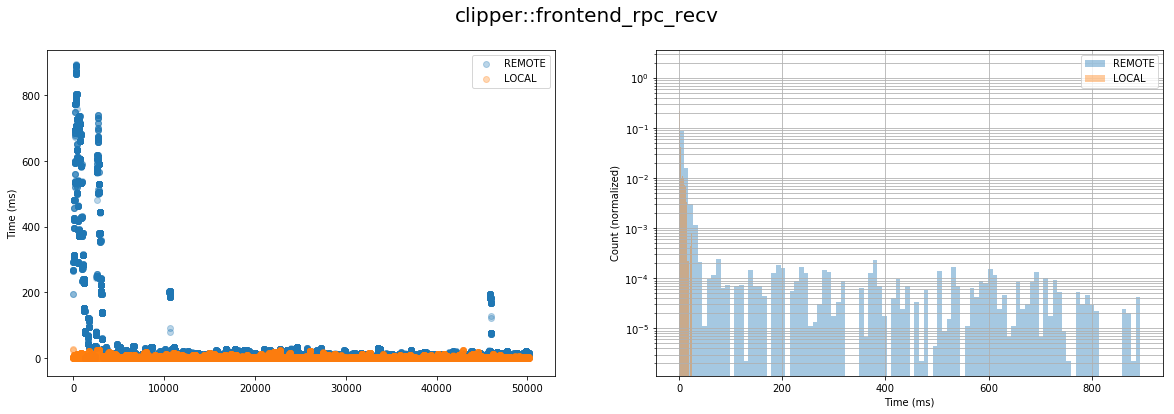

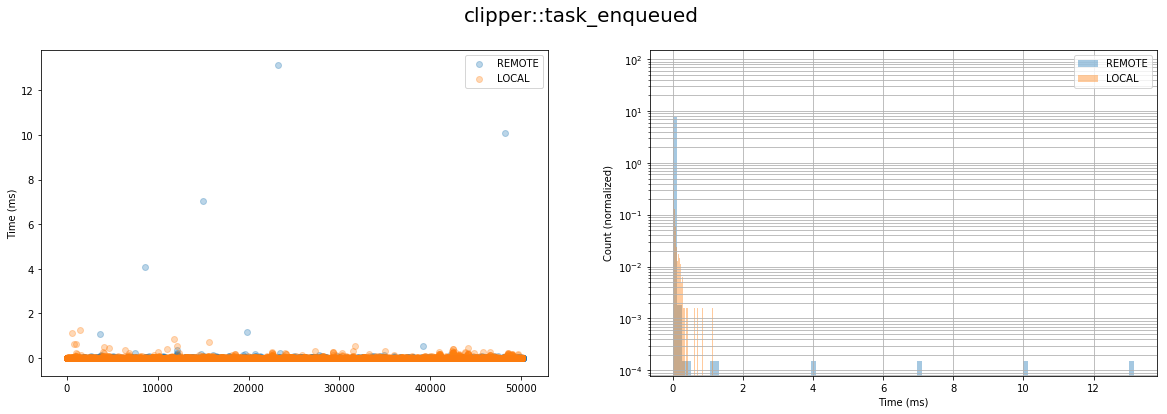

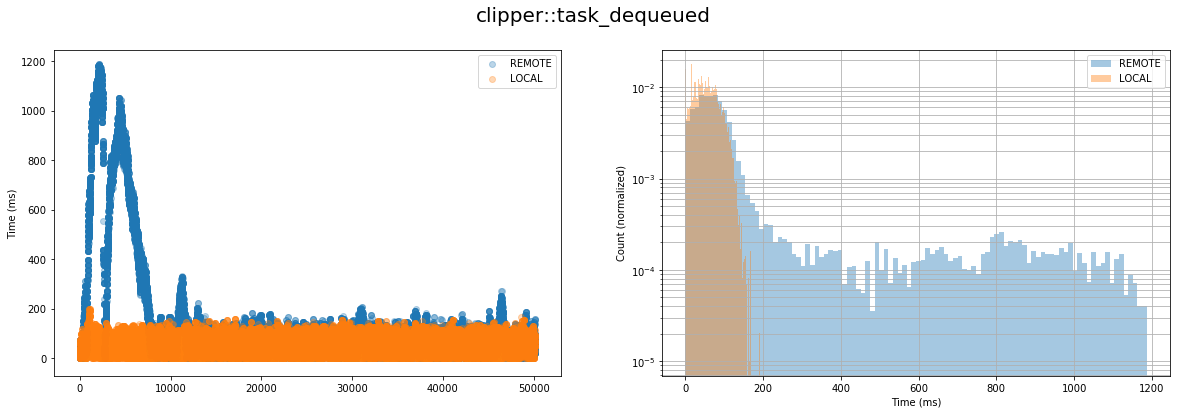

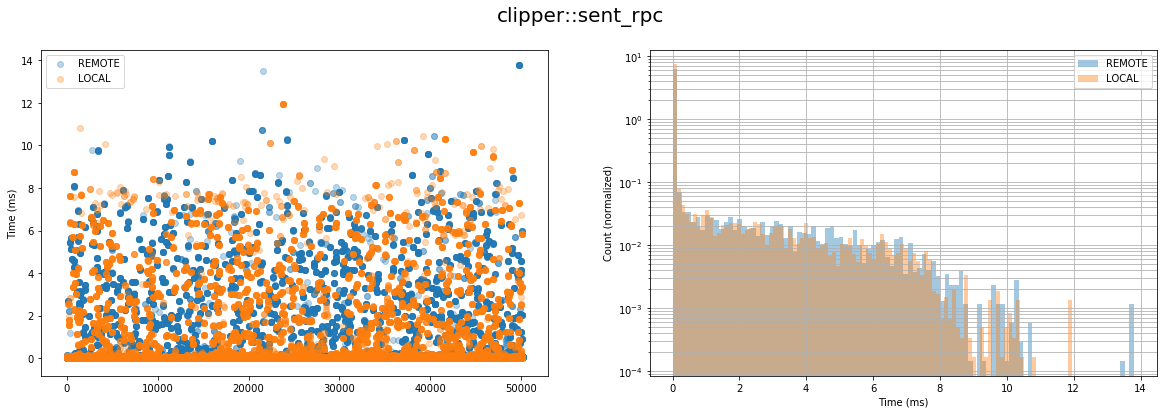

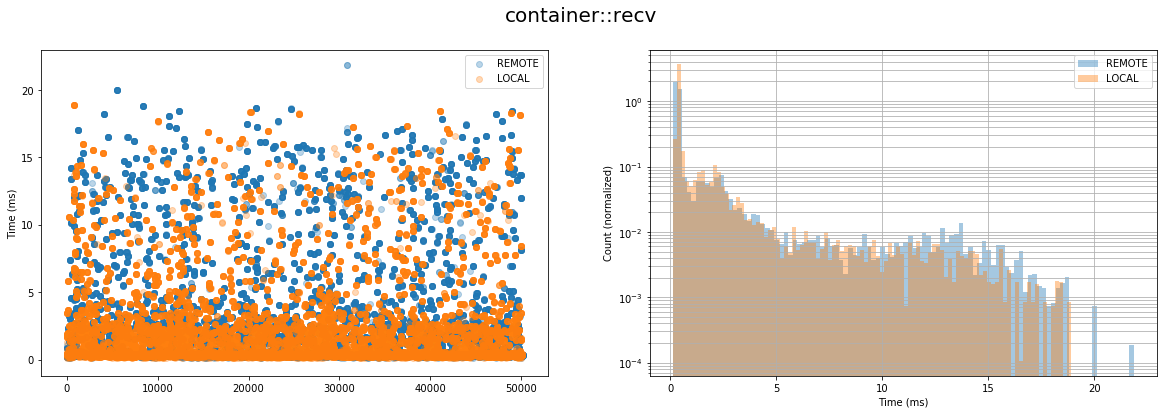

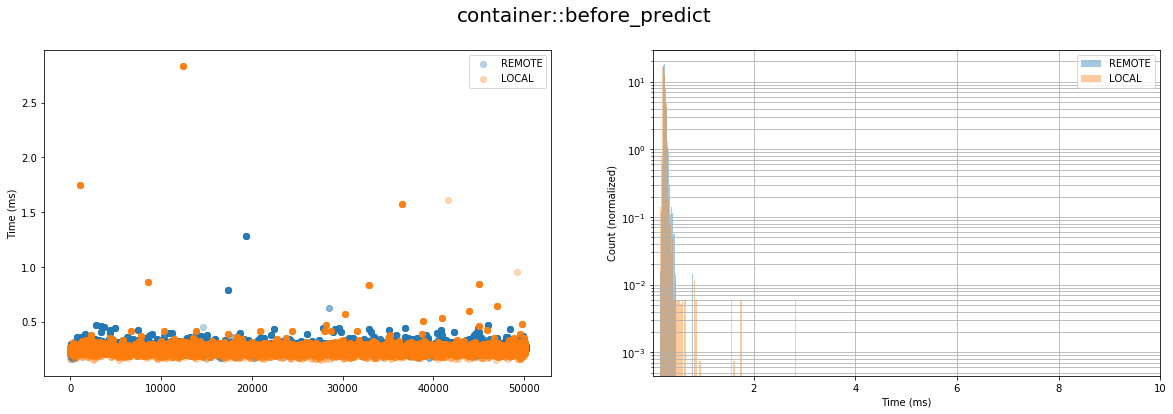

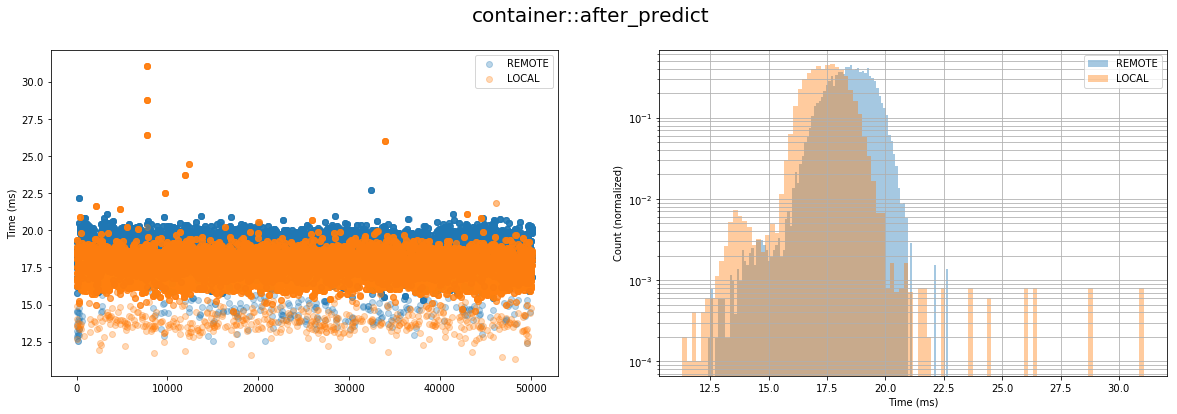

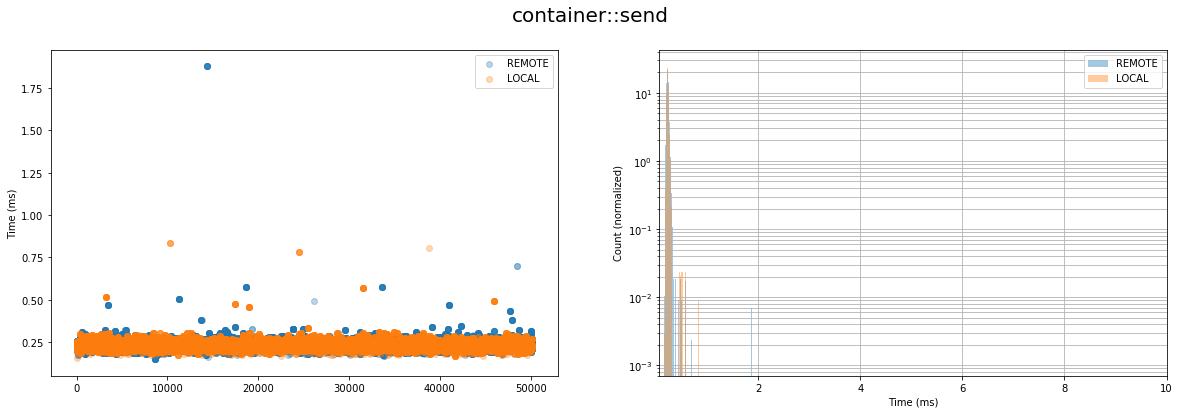

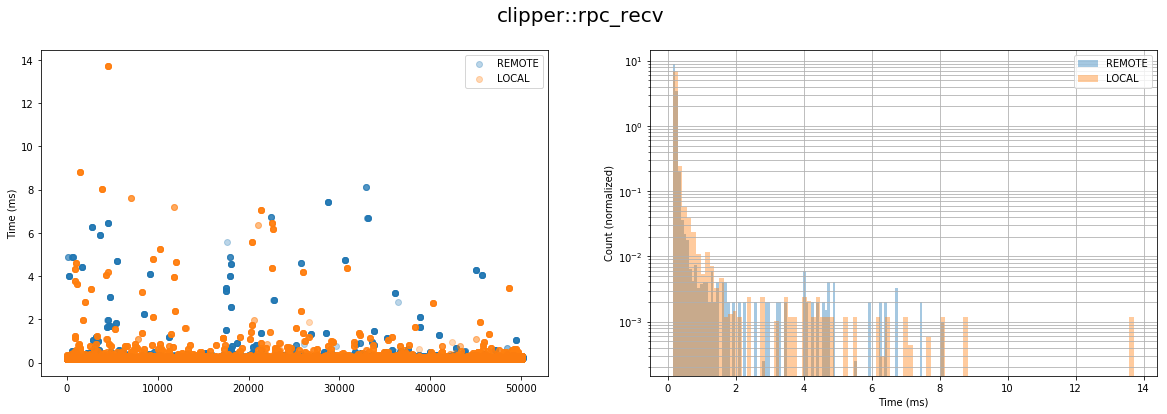

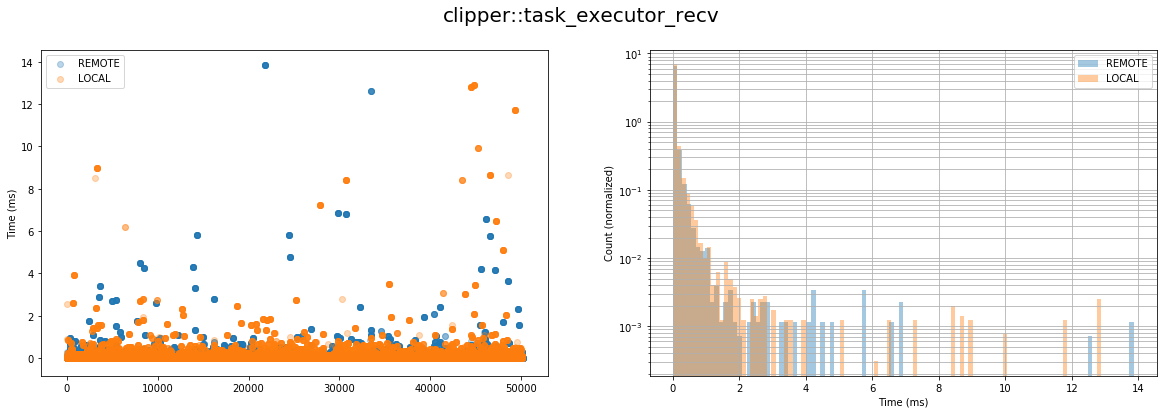

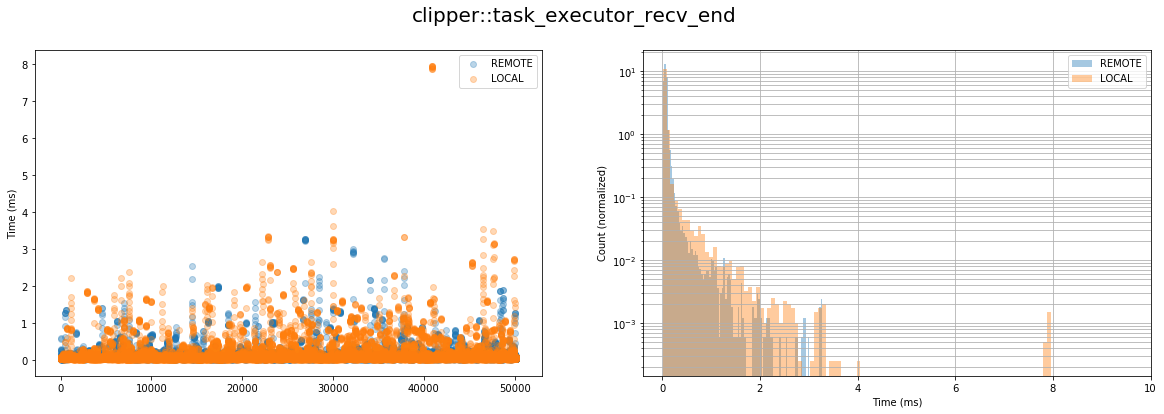

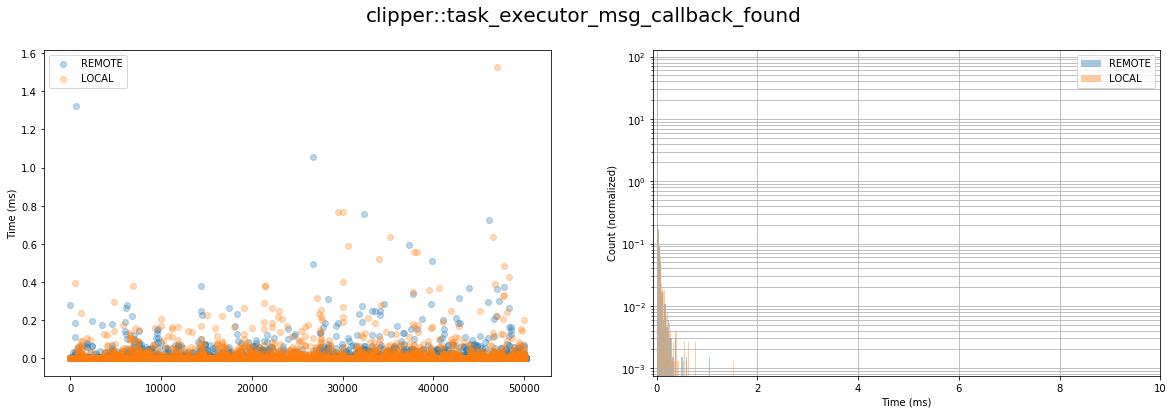

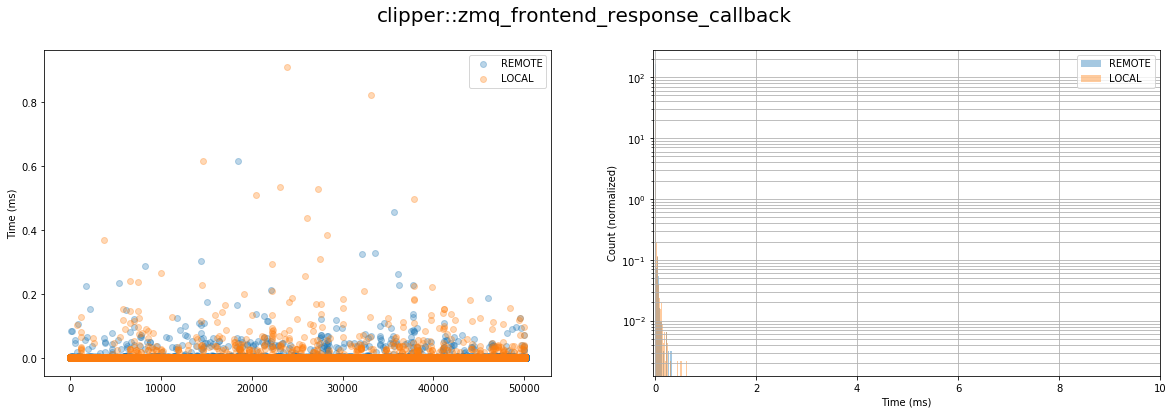

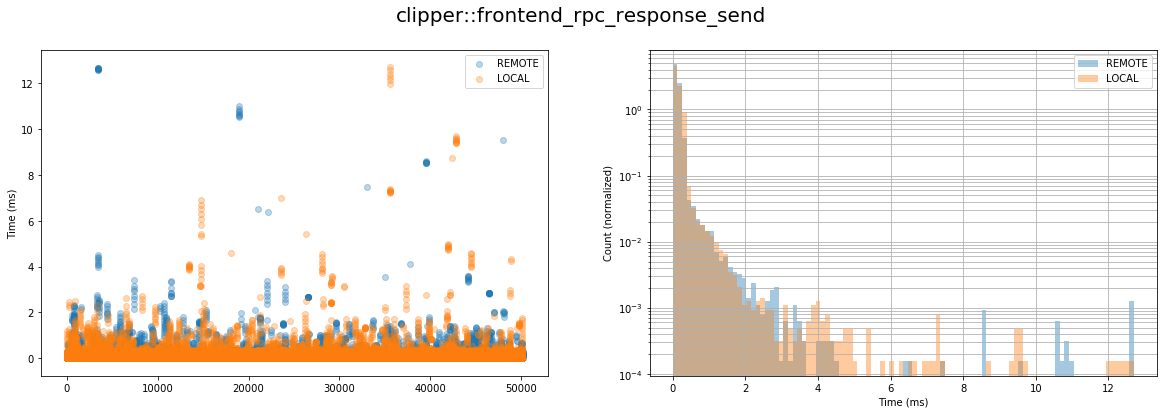

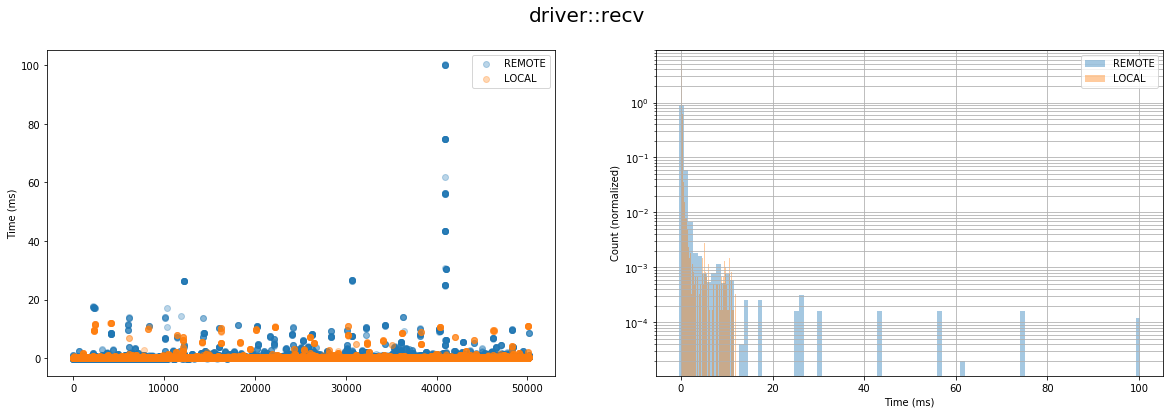

# Model: tf-resnet-feats

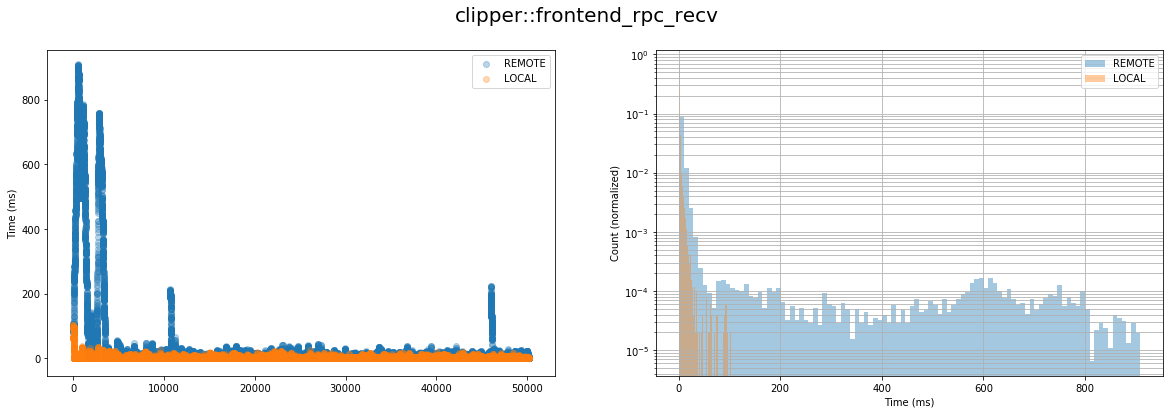

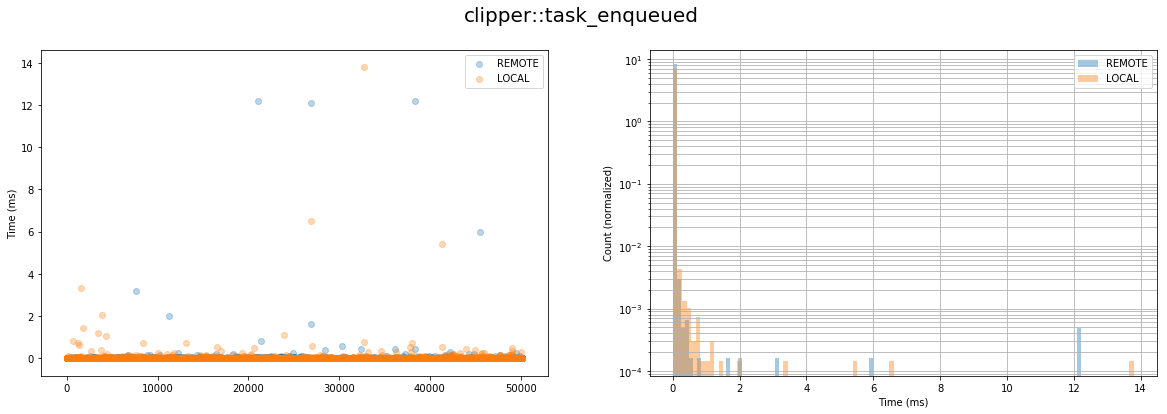

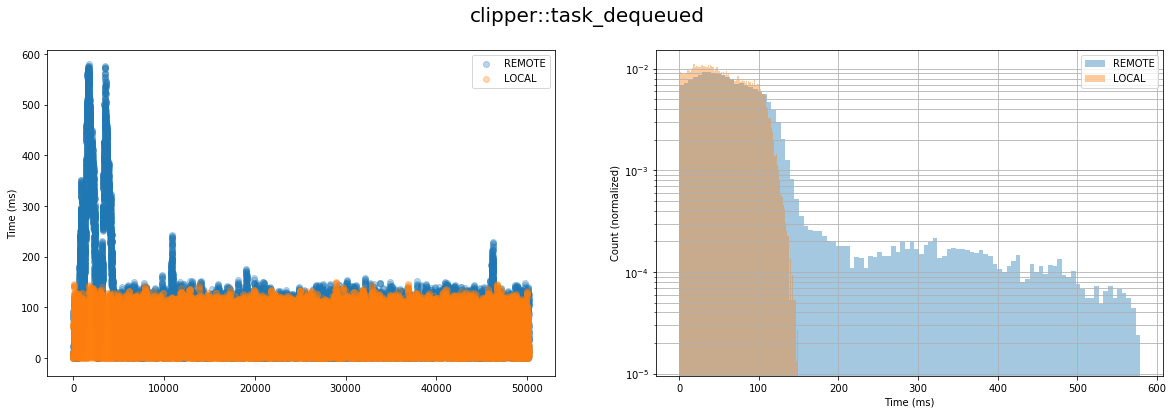

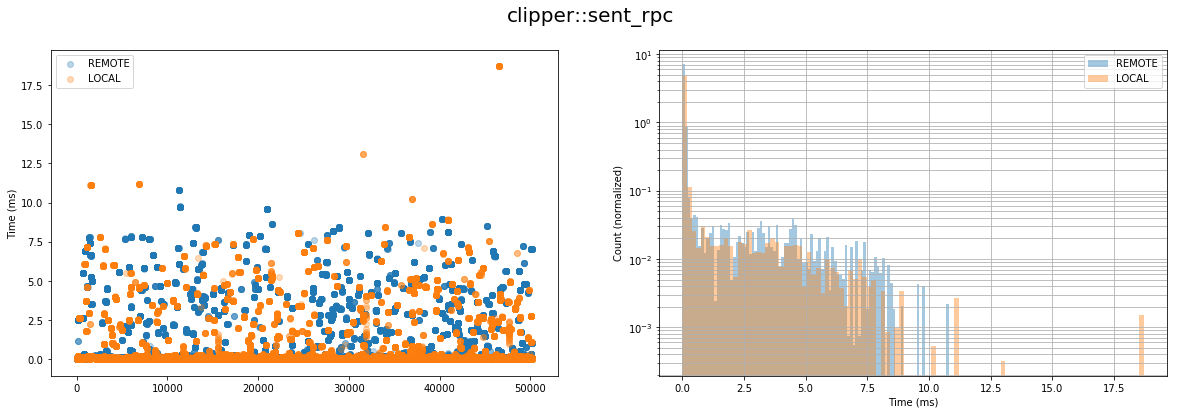

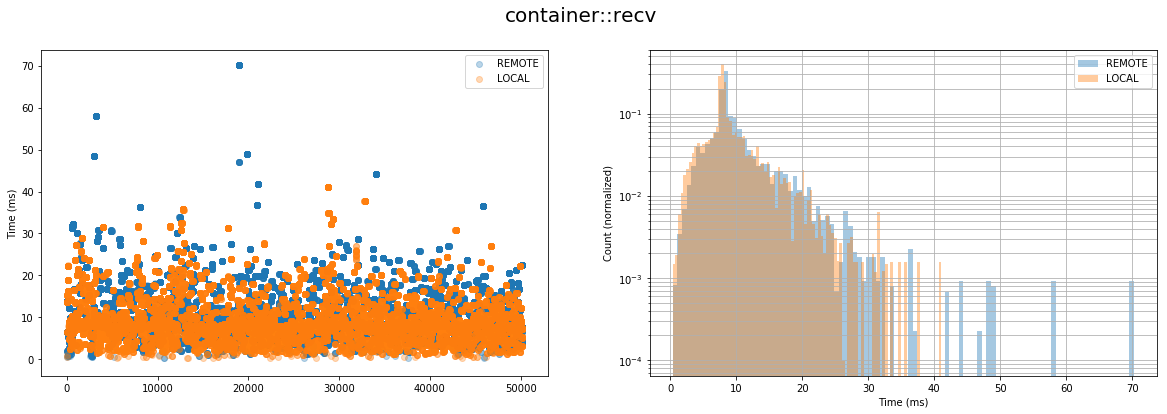

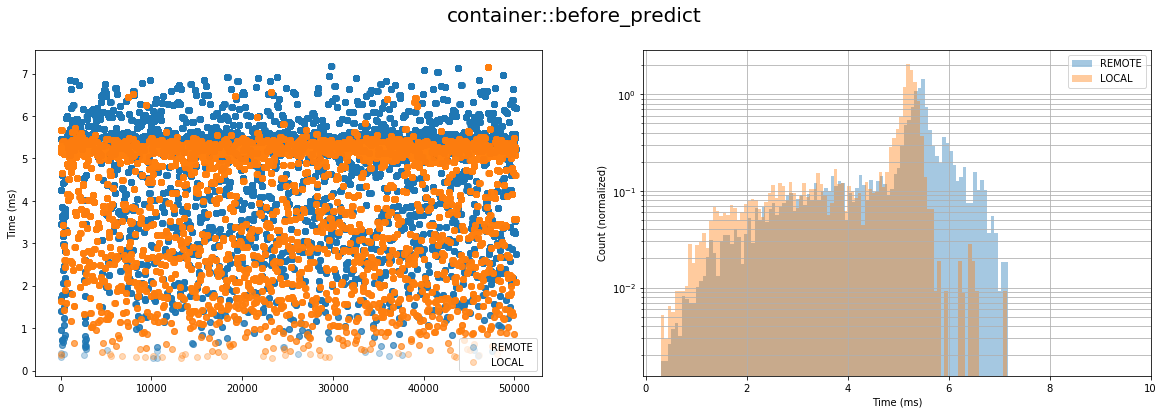

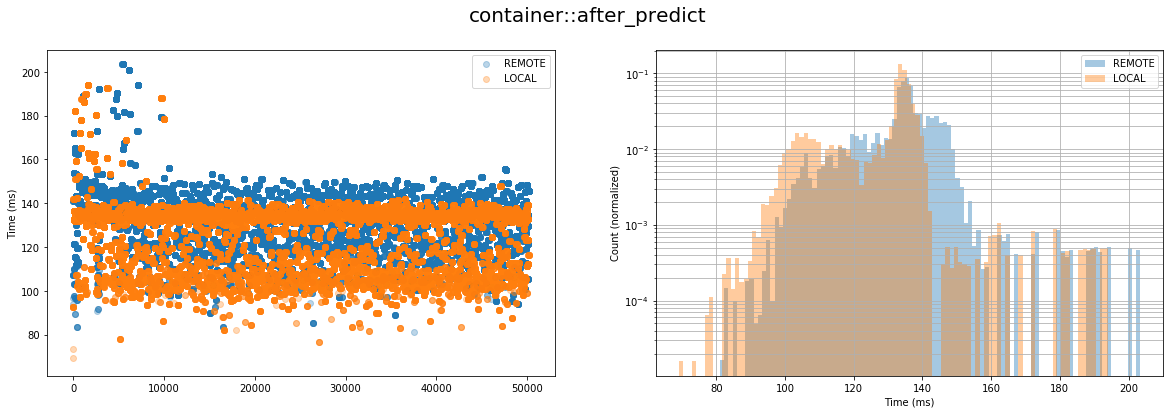

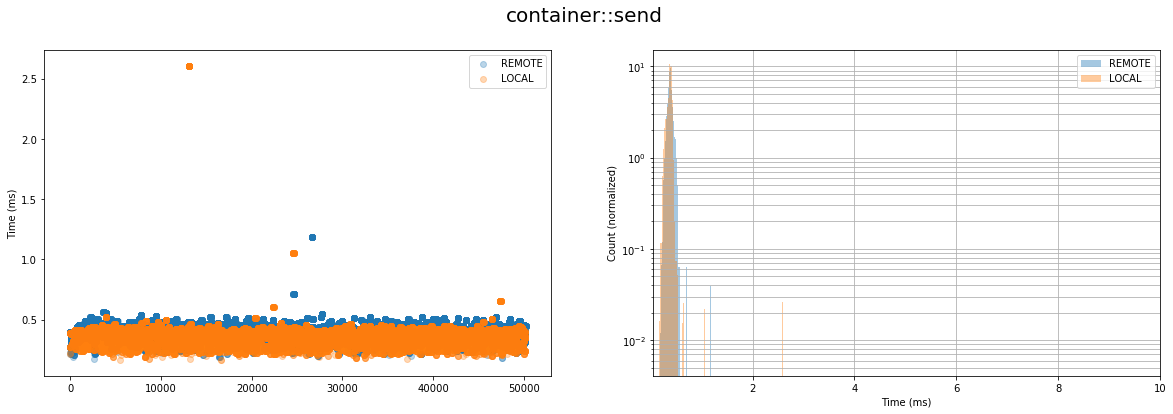

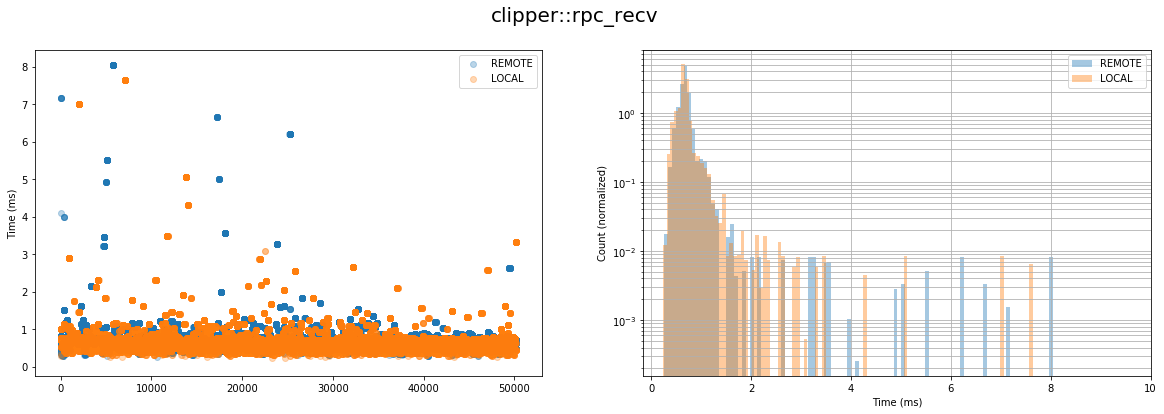

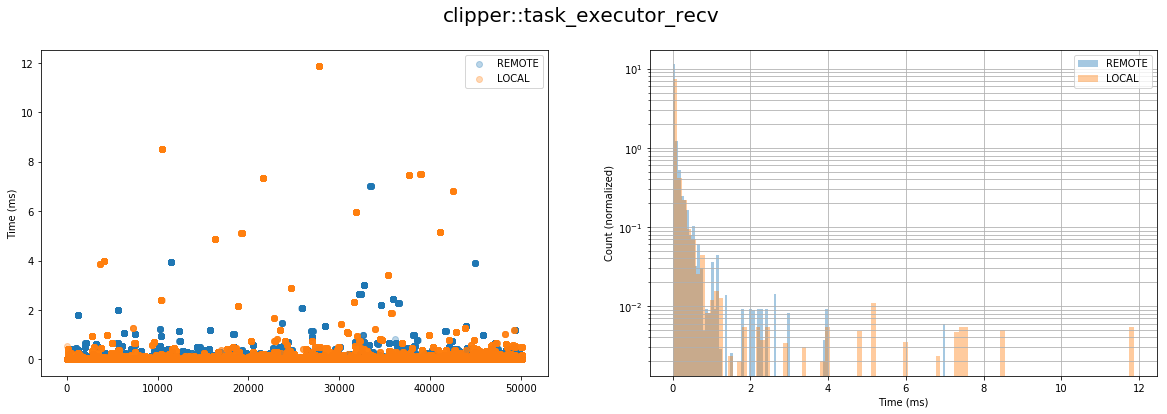

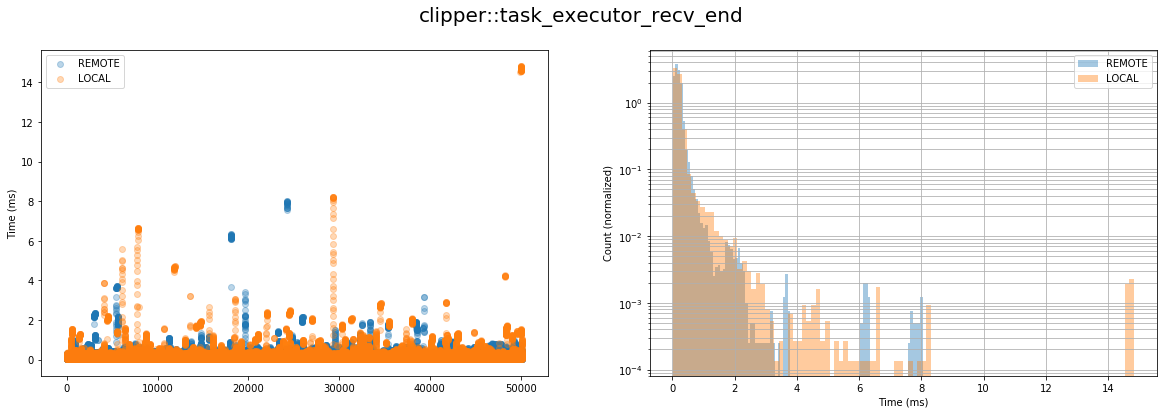

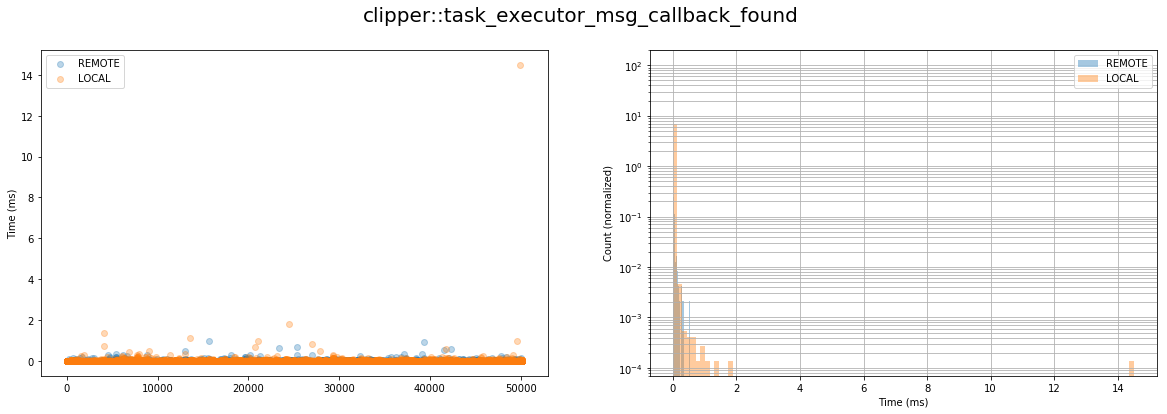

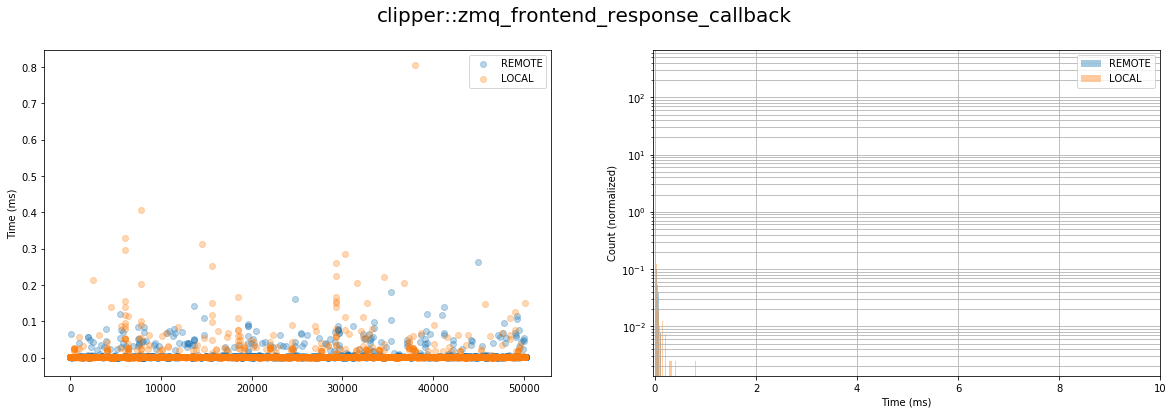

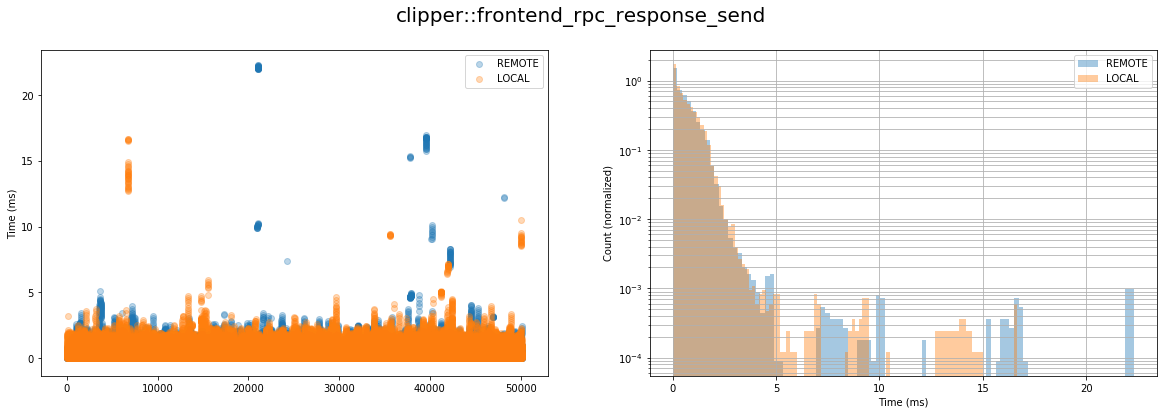

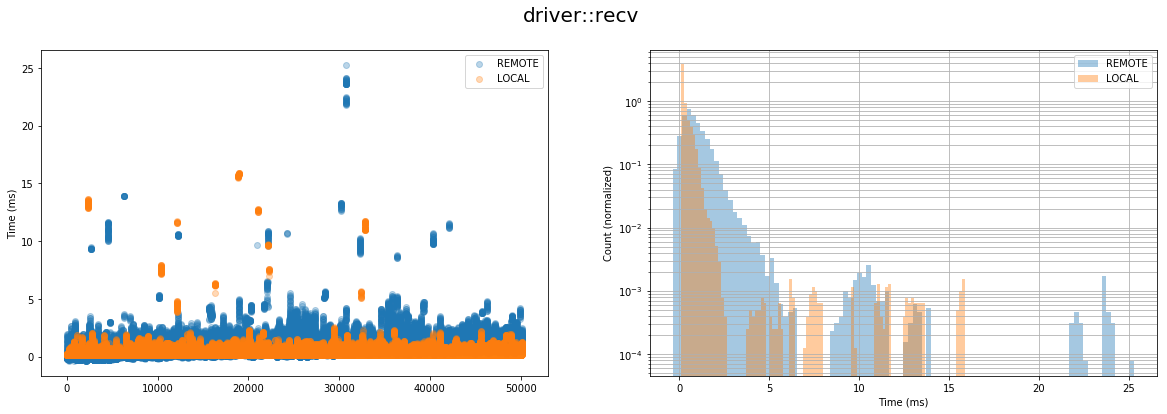

# Model: tf-log-reg

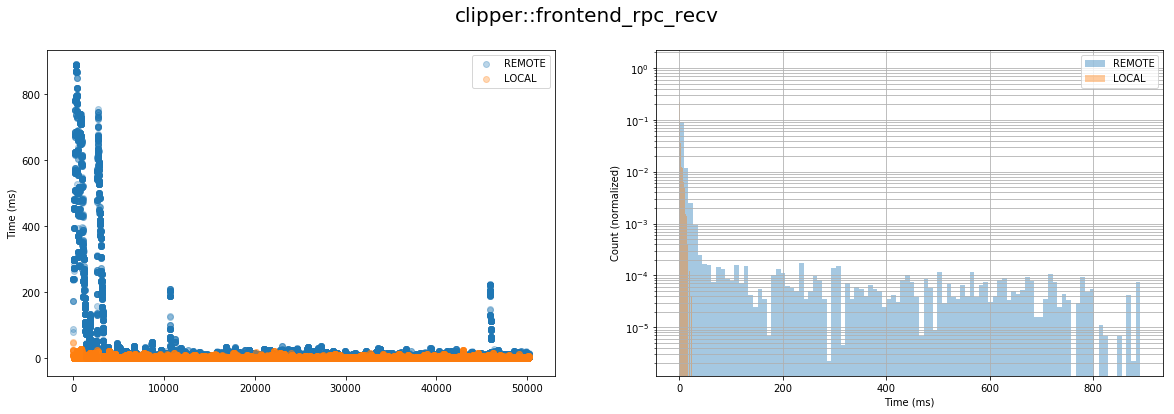

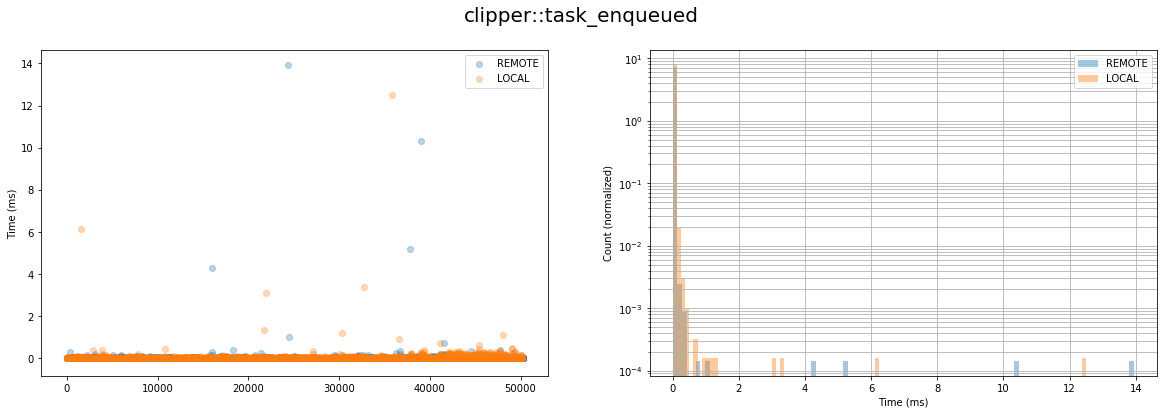

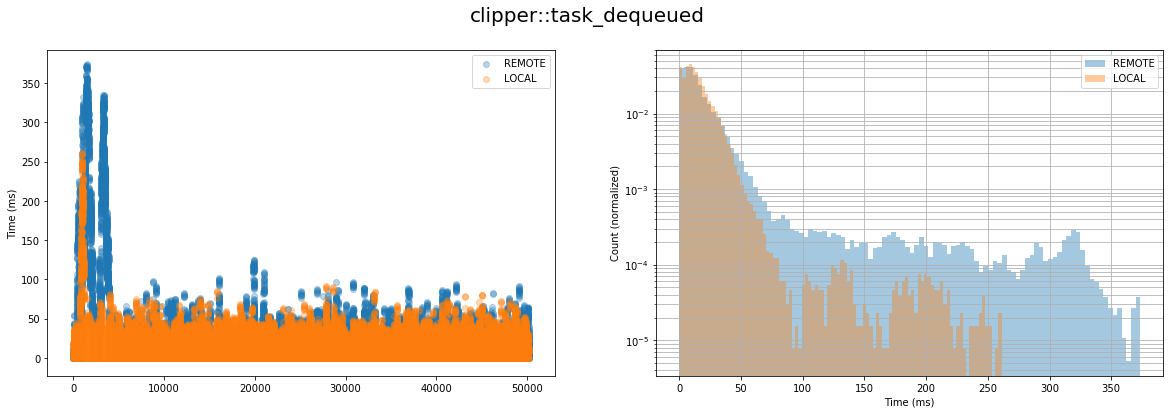

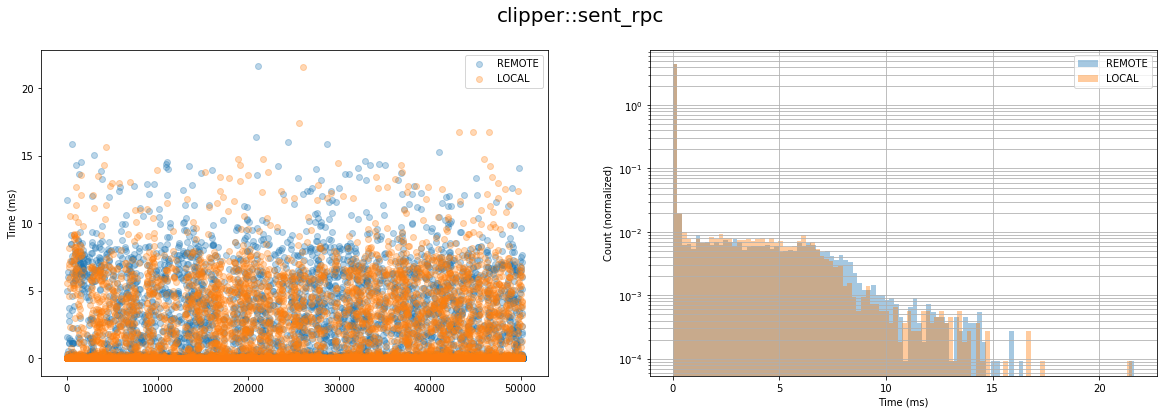

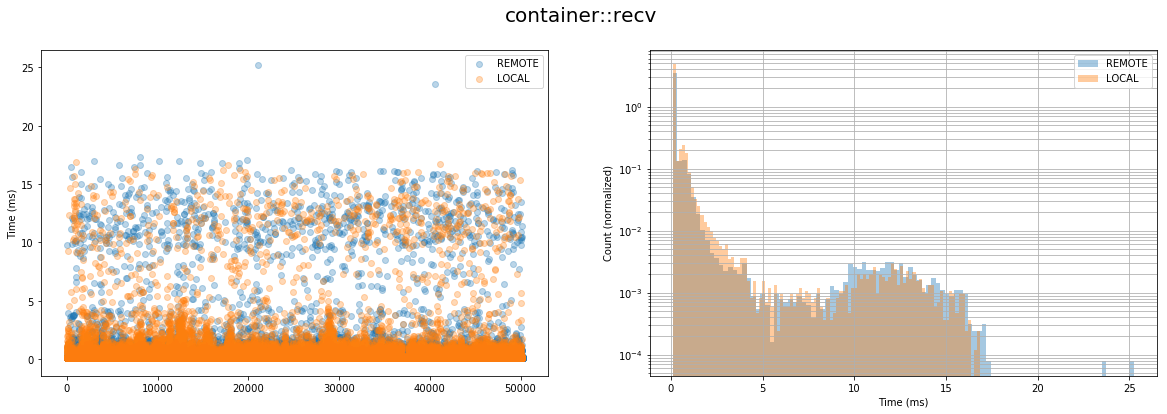

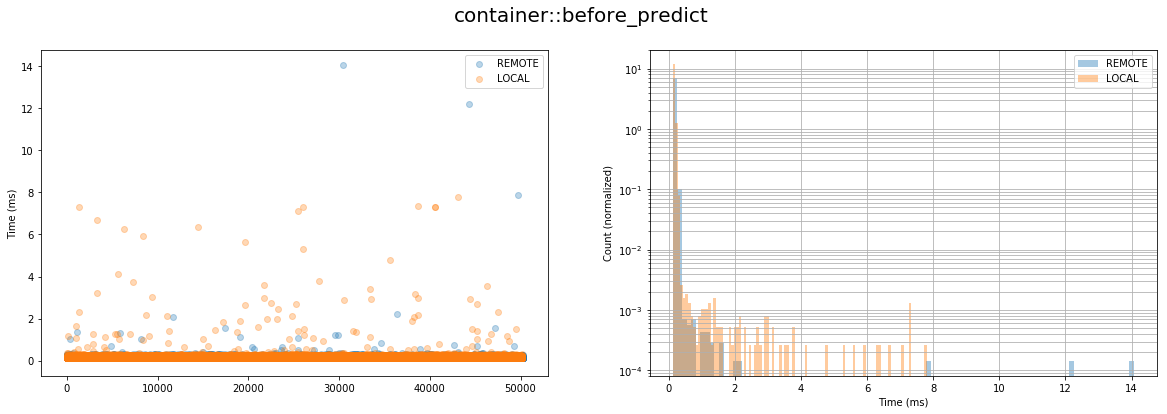

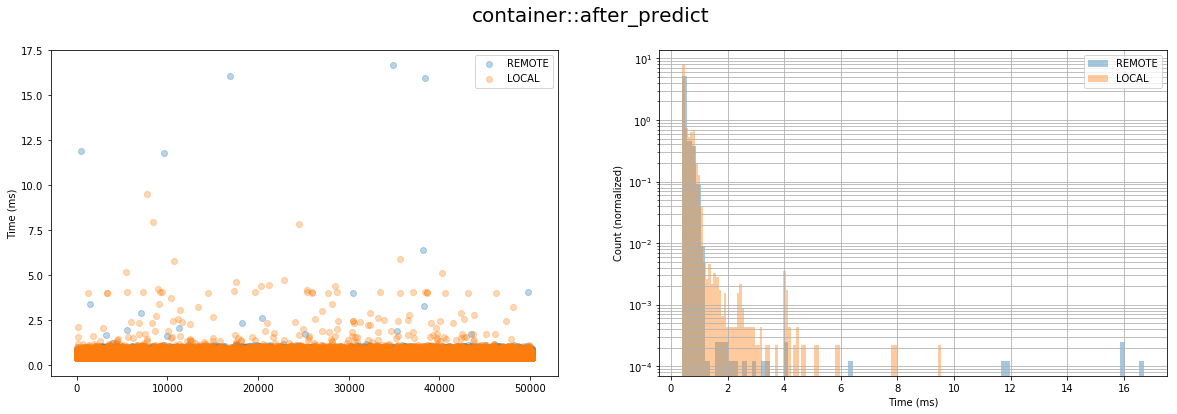

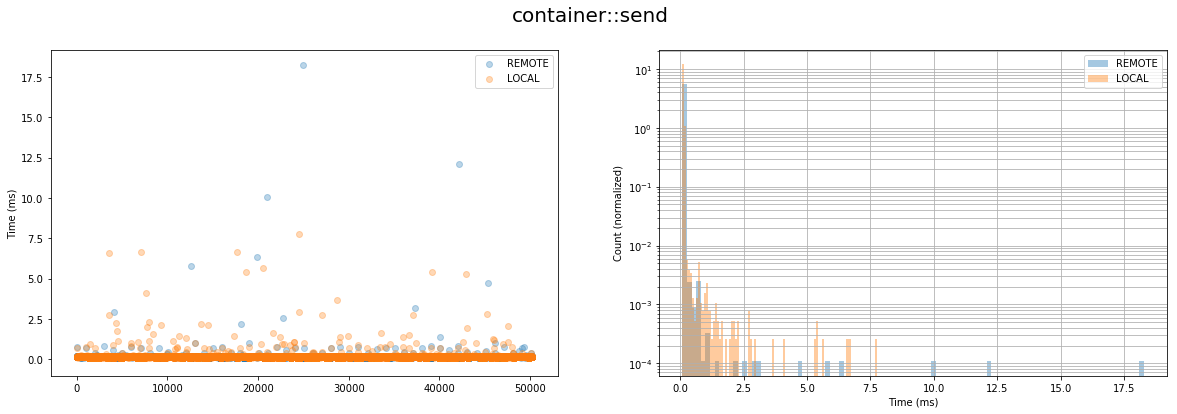

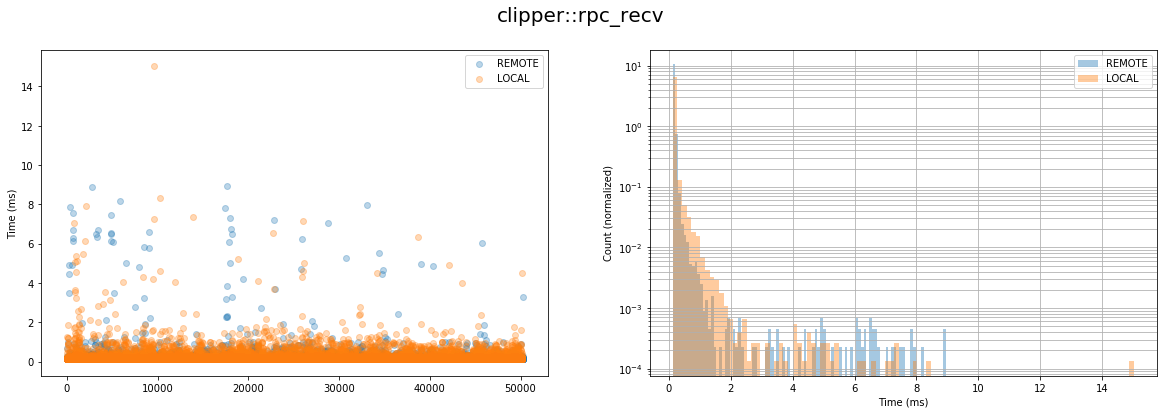

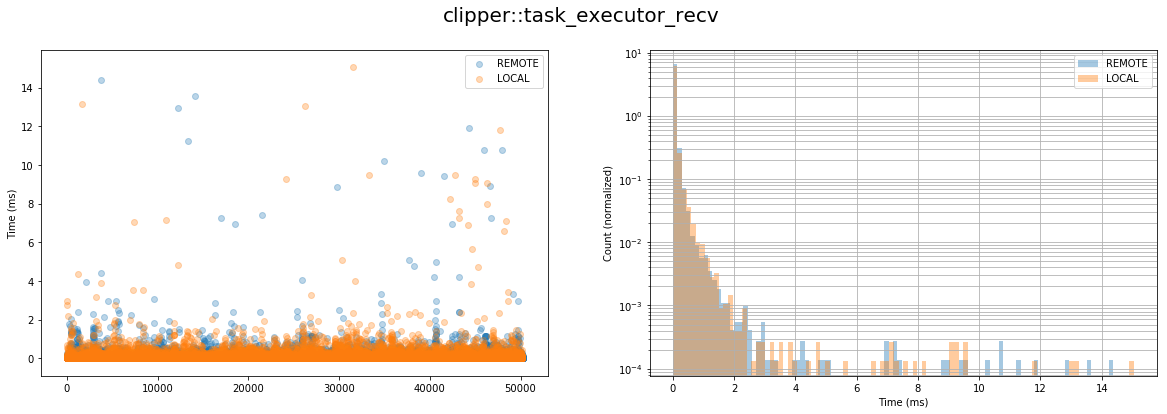

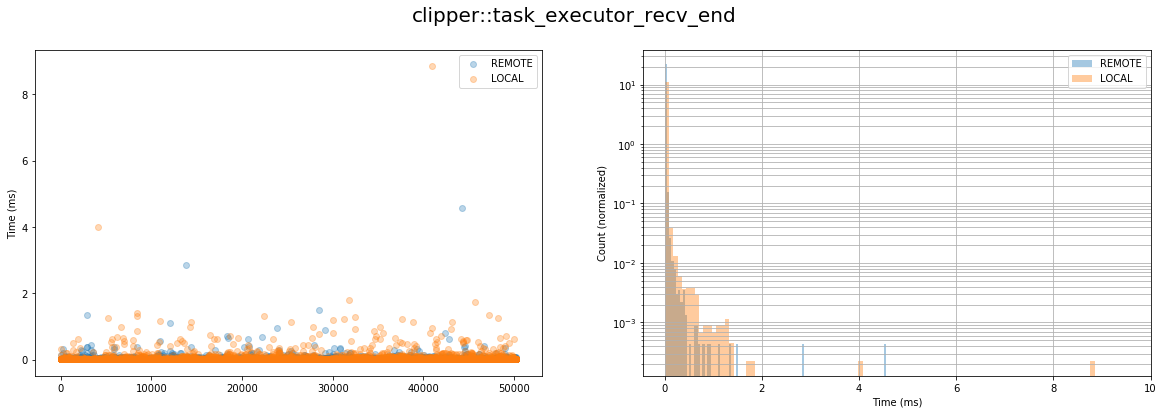

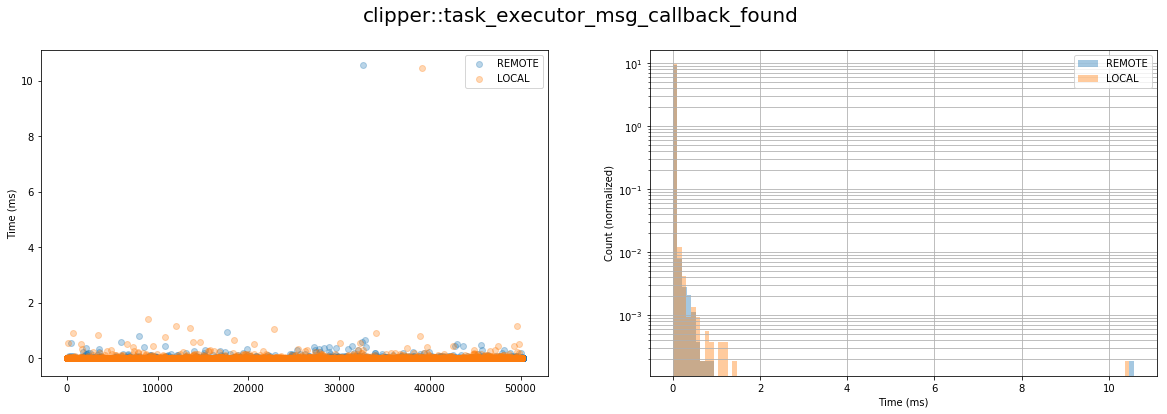

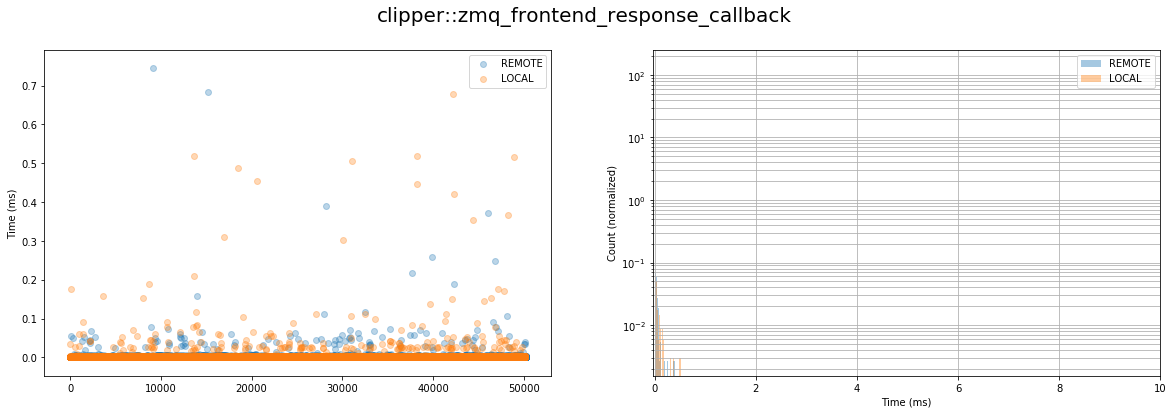

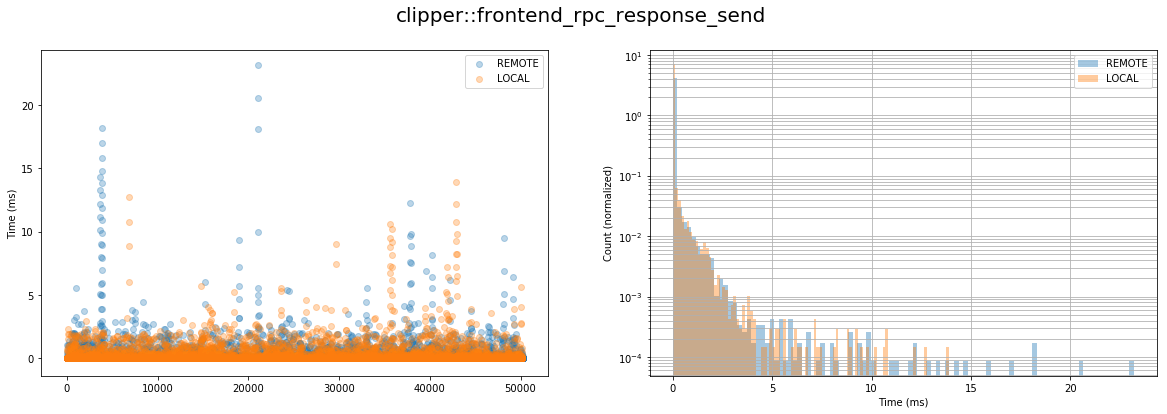

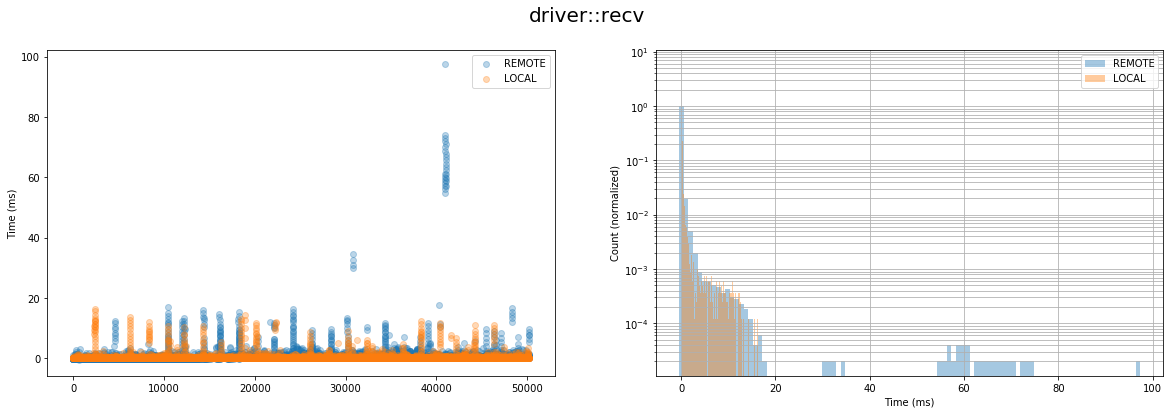

In [7]:
dir_path = "/Users/crankshaw/clipper-project/model-comp-project/plots-model-comp-paper/debugging/distributed_e2e_lower_lambda/"
files = {}
for f in os.listdir(dir_path):
    
    name = f.split("_")[0]
    files[name] = os.path.join(dir_path, f)

plots_dir = "remote_vs_local_plots_lower_lambda"
analyze_lineage(files, plots_dir)